<a href="https://colab.research.google.com/github/porhJ/UAV-Suspended-Load-Control/blob/main/perfect_drone_dance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

In [ ]:
from scipy.linalg import solve_discrete_are

$\underline q$ = $[x, z, \theta_d, \theta_p]$

# Dynamics code

This code is for simulation the drone-suspended-payload system

where state is
$$\underline{x} = [x, \dot{x}, z, \dot{z}, \theta_d, \dot{\theta_d}, \theta_p, \dot{\theta_p}]$$

In [ ]:
import numpy as np


class PackageDroneIdealDynamics:
    def __init__(self, m_d, m_p, Id_cm, r_d, l, x_ref_, u_ref_, g=9.8):
        self.m_d = m_d
        self.Id_cm = Id_cm
        self.r_d = r_d
        self.m_p = m_p
        self.l = l
        self.x_ref_ = x_ref_
        self.dx_ref_ = np.array([0, 0, 0, 0])
        self.u_ref_ = u_ref_
        self.g = g

    def dynamics(self, x_, u_):
        x, dx, z, dz, theta_d, dtheta_d, theta_p, dtheta_p = x_

        # frm M * ddq + C * dq = tau_g + Bu
        # its actually just newton's 2nd law but fancy
        # M is mass matrix (or intertia if it is in theta coordinate)
        # Thus force = tau_g + Bu - C * dq
        # So F = Ma where a is obviously ddq
        # tau_g + Bu - C * dq = M * ddq

        M = np.array(
            [
                [self.m_p + self.m_d, 0, 0, self.m_p * self.l * np.cos(theta_p)],
                [0, self.m_p + self.m_d, 0, self.m_p * self.l * np.sin(theta_p)],
                [0, 0, self.Id_cm, 0],
                [
                    self.m_p * self.l * np.cos(theta_p),
                    self.m_p * self.l * np.sin(theta_p),
                    0,
                    self.m_p * (self.l**2),
                ],
            ]
        )

        C = np.array(
            [
                [0, 0, 0, -self.l * dtheta_p * np.sin(theta_p)],
                [0, 0, 0, self.l * dtheta_p * np.cos(theta_p)],
                [0, 0, 0, 0],
                [0, 0, 0, 0],
            ]
        )

        tau_g = np.array(
            [
                [
                    0,
                    -(self.m_p + self.m_d) * self.g,
                    0,
                    -self.m_p * self.g * self.l * np.sin(theta_p),
                ]
            ]
        )
        tau_g = tau_g.T
        B = np.array(
            [
                [np.cos(theta_d), np.cos(theta_d)],
                [np.sin(theta_d), np.sin(theta_d)],
                [self.r_d, -self.r_d],
                [0, 0],
            ]
        )

        q_dot = np.array([[dx, dz, dtheta_d, dtheta_p]])
        q_dot = q_dot.T

        force = tau_g + B @ u_ - C @ q_dot
        # we want ddq, thus we use inv(M), but this is lowkey unsafe, so we just gonna use np.linalg.solve, it is safer. source: trust me bro
        ddq = np.linalg.solve(M, force).flatten()
        ddx, ddz, ddtheta_d, ddtheta_p = ddq

        # we gonna return dx_
        return np.array([dx, ddx, dz, ddz, dtheta_d, ddtheta_d, dtheta_p, ddtheta_p])

    def get_jacobian(self, x_, u, eps=1e-6):
        n = len(x_)
        m = 2
        Df_Dx = np.zeros((n, n))
        B = np.zeros((n, m))
        f0 = self.dynamics(x_, u)

        for i in range(n):
            y_perturb = x_.copy()
            y_perturb[i] += eps
            f_perturb = self.dynamics(y_perturb, u)
            Df_Dx[:, i] = (f_perturb - f0) / eps

        for j in range(m):
            u_perturb = self.u_ref_.copy()
            u_perturb[j] += eps
            f_perturb_u = self.dynamics(x_, u_perturb)
            B[:, j] = (f_perturb_u - f0) / eps

        return Df_Dx, B

    def linearized_dynamics(self, x_, u_, A, B):
        delta_x_ = x_ - self.x_ref_
        delta_u_ = u_ - self.u_ref_
        delta_dx_ = A @ delta_x_ + B @ delta_u_
        dx_ = self.dx_ref_ + delta_dx_
        return dx_

# Visualization code

In [ ]:
import math

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from matplotlib.patches import Polygon

def plot_state_history(
    hist,
    hist_hat=None,
    t=None,
    state_names=None,
    figsize=(12, 8),
    sharex=True,
    plot_error=False,
    markers_every=None,
    savepath=None,
):
    """
    plot a lot of graphs:
        1. RMSE
        2. error of each variable vs time
        3. true vs estimate of each variable
    I vibed this, edited it, and now it is beautiful.
    """

    hist = np.asarray(hist)
    T, n = hist.shape
    if hist_hat is not None:
        hist_hat = np.asarray(hist_hat)
        assert hist_hat.shape == (T, n), "hist_hat shape must match hist"
    if t is None:
        t = np.arange(T)
    else:
        t = np.asarray(t)
        assert len(t) == T

    if state_names is None:
        state_names = [f"s{i}" for i in range(n)]
    assert len(state_names) == n

    ncols = 2 if n > 3 else 1
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=sharex)
    # axes can be 2D/1D scalar -- normalize to 1D list
    if nrows * ncols == 1:
        axes = np.array([axes])
    else:
        axes = axes.flatten()




    for i in range(n):
        ax = axes[i]
        ax.plot(t, hist[:, i], "-", label="true")
        if hist_hat is not None:
            ax.plot(t, hist_hat[:, i], "--", label="est")
        if markers_every is not None and markers_every > 0:
            ax.plot(t[::markers_every], hist[::markers_every, i], "o", markersize=3)
            if hist_hat is not None:
                ax.plot(
                    t[::markers_every], hist_hat[::markers_every, i], "x", markersize=3
                )

        ax.set_ylabel(state_names[i])
        ax.grid(True)
        ax.legend(loc="upper right", fontsize="small")

    # hide any unused subplots
    for j in range(n, len(axes)):
        axes[j].axis("off")

    if sharex:
        axes[-1].set_xlabel("time (step)" if t is None else "time")

    plt.tight_layout()
    if savepath:
        fig.savefig(f"{savepath}_states.png", dpi=200)

    if plot_error and hist_hat is not None:
        errors = hist - hist_hat  # shape (T, n)
        fig2, ax2 = plt.subplots(figsize=(max(8, ncols * 4), 4))
        # plot each error with small alpha to keep it compact
        for i in range(n):
            ax2.plot(t, errors[:, i], label=state_names[i], linewidth=0.9)
        ax2.set_title("Estimation error (true - est)")
        ax2.set_xlabel("time")
        ax2.grid(True)
        ax2.legend(ncol=min(4, n), fontsize="small", loc="upper right")
        plt.tight_layout()
        if savepath:
            fig2.savefig(f"{savepath}_errors.png", dpi=200)

    if hist_hat is not None:
        rmse = np.sqrt(((hist - hist_hat) ** 2).mean(axis=0))
        fig3, ax3 = plt.subplots(figsize=(max(8, ncols * 4), 3))
        ax3.bar(np.arange(n), rmse)
        ax3.set_xticks(np.arange(n))
        ax3.set_xticklabels(state_names, rotation=45, ha="right")
        ax3.set_ylabel("RMSE")
        ax3.set_title("Per-state RMSE")
        plt.tight_layout()
        if savepath:
            fig3.savefig(f"{savepath}_rmse.png", dpi=200)

    x_hist = hist[:, 0]
    z_hist = hist[:, 2]

    fig4, ax4 = plt.subplots(figsize=figsize)
    ax4.set_title("Trajectory path")
    ax4.set_xlabel("x")
    ax4.set_ylabel("z")
    ax4.grid(True)
    ax4.axis("equal")
    ax4.scatter(x_hist[-1], z_hist[-1], color="r")
    ax4.plot(x_hist, z_hist)

    plt.show()

# Metrics compute

In [ ]:
def compute_metrics(hist, u_ref_, u_hist, t_settle, dt = 1.0e-3):

  theta_p_hist = hist[:, 6]
  max_p_angle_degree = np.max(theta_p_hist) * (180 / np.pi)
  print("Max package swing (degree): ", max_p_angle_degree)

  control_effort = np.mean(np.abs(u_hist - u_ref_), axis=0)
  print("Control Effort Motor 1:", control_effort[0])
  print("Control Effort Motor 2:", control_effort[1])

  if t_settle != 0:
    print(f"Settling after: {t_settle * dt} seconds")
  else:
    print("The drone never settle")

In [ ]:
def compute_settle_time(x, z, dx, dz, theta_p, step):
  if (
    abs(x - x_ref) < 0.05 and
    abs(z - z_ref) < 0.05 and
    abs(dx) < 0.05 and
    abs(dz) < 0.05 and
    abs(theta_p) < np.deg2rad(10)
):
    return True

In [ ]:
def compute_rmse(hist, hist_hat):
  error = hist - hist_hat
  rmse = np.sqrt(np.mean(error**2, axis=0))
  return rmse

# Controller

In [ ]:
import numpy as np
from scipy.linalg import solve_discrete_are


class lqr_controller:
    def __init__(self, x_ref_, u_ref_, A, B, Ki):
        self.x_ref_ = x_ref_
        self.u_ref_ = u_ref_
        self.A = A
        self.B = B
        self.Ki = Ki

    def get_Kr_(self, A, B, Q, R):
        P = solve_discrete_are(A, B, Q, R)
        return np.linalg.inv(R) @ B.T @ P

    def control_law(self, x_, int_, Kr):
        error_x = (x_ - self.x_ref_).reshape(-1, 1)
        error_int = int_.reshape(-1, 1)
        delta_u = -Kr @ error_x + self.Ki @ error_int
        return self.u_ref_ + delta_u

    def step(self, system, x_, Kr, int_, dt=1.0e-3):
        int_ += (self.x_ref_ - x_) * dt
        u_ = self.control_law(x_, int_, Kr)
        dx_ = system.dynamics(x_, u_)
        return x_ + dx_ * dt, int_


# Setup

In [ ]:
SEED = 42


In [ ]:
m_d = 5
m_p = 2
M = m_d + m_p
g = 9.8
r_d = 0.5
Id_cm = 1 / 12 * m_d * (2 * r_d) ** 2
l = 0.5
x_ref = 5
z_ref = 5
x_ref_ = np.array([x_ref, 0, z_ref, 0, 0.5 * np.pi, 0, 0, 0])
u_ref_ = np.array([[0.5 * M * g, 0.5 * M * g]])
u_ref_ = u_ref_.T
Ki = np.array([[0, 0, 5, 0, 0, 0, 0, 0], [0, 0, 5, 0, 0, 0, 0, 0]])
int_ = 0
int_ = 0
t_terminate = 0
dt = 1.0e-3
systemDynamics = PackageDroneIdealDynamics(m_d, m_p, Id_cm, r_d, l, x_ref_, u_ref_)
A, B = systemDynamics.get_jacobian(x_ref_, u_ref_)
A = np.eye(len(A)) + A * dt
B = B * dt
C = np.array(
    [
        [1, 0, 0, 0, 0, 0, 0, 0],  # sensor for x
        [0, 0, 1, 0, 0, 0, 0, 0],  # sensor for z
        [0, 0, 0, 0, 1, 0, 0, 0],  # imu
    ]
)
# if using C = [1, 0, 1, 0, 0, 0, 0, 0], it implies =Nonethat it is one sensor that can measure both x and z, the rank will be insufficient.
# and that is NOT smart at alllllllllllllllll yoooooooooooooo

u_min = np.array([0.0, 0.0])
u_max = np.array([1.5 * (m_d + m_p) * g, 1.5 * (m_d + m_p) * g])

# Experiment

- R_noise_x = 0.8^2 (based on u-blox NEO-M8N)
- R_noise_z = 0.1^2 (based on Bosch BMP388 / BMP390)
- R_noise_imu = 0.02^2 (based on Bosch BMI088)
- start at (0, 0) -> (5, 5)

## Baseline
- No disturbance, only sensors noise

In [ ]:
Q_noise = np.eye(8) * 0.001
R_noise = np.diag([0.8**2, 0.1**2, 0.02**2])

In [ ]:
def baselineSimulation(Q, R, Q_noise, R_noise, seed = 0):
  rng = np.random.default_rng(seed=seed)
  lqr = lqr_controller(x_ref_, u_ref_, A, B, Ki)
  Kr = lqr.get_Kr_(A, B, Q, R)
  x_ = np.array([0, 0, 0, 0, 0.25 * np.pi - 1.0e-3, 0, 0 + 1.0e-3, 0])
  x_hat_ = np.array(
      [0, 0, 0, 0, 0.25 * np.pi, 0, 0, 0]
  )  # initial estmated x
  P = np.eye(8) * 0.1
  integrator_limit = 10.0
  u_min = np.array([0.0, 0.0])
  u_max = np.array([1.5 * (m_d + m_p) * g, 1.5 * (m_d + m_p) * g])
  # main loop
  int_ = np.zeros_like(x_)
  steps = 20000
  hist = []
  u_hist = []
  hist_hat = []
  t_terminate = 0
  for step in range(steps):
    # in controller, it shouldnt have access to the world, it should only know what it can percieve by sensors
    int_ += (x_ref_ - x_hat_) * dt

    u_ = lqr.control_law(x_hat_, int_, Kr)
    u_ = np.clip(u_.flatten(), u_min, u_max)
    u_ = np.reshape(u_, (2, 1))


    dx_hat_pred = systemDynamics.dynamics(x_hat_, u_)
    x_hat_pred_ = x_hat_ + dx_hat_pred * dt
    Df_Dx, _ = systemDynamics.get_jacobian(x_hat_, u_)
    F = np.eye(8) + Df_Dx * dt

    P_pred = F @ P @ F.T + Q_noise

    # simulation, this is the real world
    dx_ = systemDynamics.dynamics(x_, u_)
    # dx_[1] += 0.1 * np.sin(2 * np.pi * 1.5 * (step * dt))

    x_ += dx_ * dt

    # measure
    sigma = np.array([0.8, 0.1, 0.02])
    sensor_noise = rng.normal(0, sigma)
    y_ = C @ x_ + sensor_noise
    y_err_ = y_ - (C @ x_hat_pred_)
    S = C @ P_pred @ C.T + R_noise
    Kf = P_pred @ C.T @ np.linalg.solve(S, np.eye(len(S)))

    x_hat_ = x_hat_pred_ + Kf @ y_err_
    P = (np.eye(8) - Kf @ C) @ P_pred

    # remember the past ahh code
    # karn dern tarng korng chun lae ther kue karn rien ruuuu ahh
    x, dx, z, dz, theta_d, dtheta_d, theta_p, dtheta_p = x_
    x_hat, _, z_hat, _, theta_d_hat, _, theta_p_hat, _ = x_hat_
    hist.append(x_.copy())
    hist_hat.append(x_hat_.copy())

    u_hist.append(u_)

    if abs(x - x_ref) < 0.05 and abs(z - z_ref) < 0.05 and t_terminate == 0:
        t_terminate = step

  hist = np.array(hist)
  hist_hat = np.array(hist_hat)

  hist[:, 4] = np.arctan2(np.sin(hist[:, 4]), np.cos(hist[:, 4]))
  hist[:, 6] = np.arctan2(np.sin(hist[:, 6]), np.cos(hist[:, 6]))

  hist_hat[:, 4] = np.arctan2(np.sin(hist_hat[:, 4]), np.cos(hist_hat[:, 4]))
  hist_hat[:, 6] = np.arctan2(np.sin(hist_hat[:, 6]), np.cos(hist_hat[:, 6]))


  states_name = [
      "x",
      "velocity_x",
      "z",
      "velocity_z",
      "theta_d",
      "angular_velocity_d",
      "theta_p",
      "angular_velocity_p",
  ]

  plot_state_history(hist, hist_hat, state_names=states_name, plot_error=True)

  return hist, hist_hat, u_hist, t_terminate

Q, R intuition
- Qₓ, Q_z: penalize position error; higher → faster convergence, but too high → aggressive maneuvers and larger payload swing.

- Q_{vₓ}, Q_{v_z}: penalize speed; higher → safer for payload (limits induced swing) and reduces overshoot.

- Q_{θ_d}, Q_{ω_{θ_d}}: keep drone attitude near horizontal; penalize large tilt and fast attitude changes to avoid motor saturation and structural stress.

- Q_{θ_p}, Q_{ω_{θ_p}}: highest priority if you want to protect the package. Penalize payload angle strongly (θ_p) and its rate to prevent oscillation.

- R (u₁,u₂): penalize actuator effort. Larger R → smoother, safer thrusts; smaller R → more aggressive control. Keep R so commanded thrusts remain within physical bounds (no motor saturation).

In [ ]:
Q = np.diag([25, 20, 25, 20, 15, 10, 30, 10])
R = np.diag([0.5, 0.5])

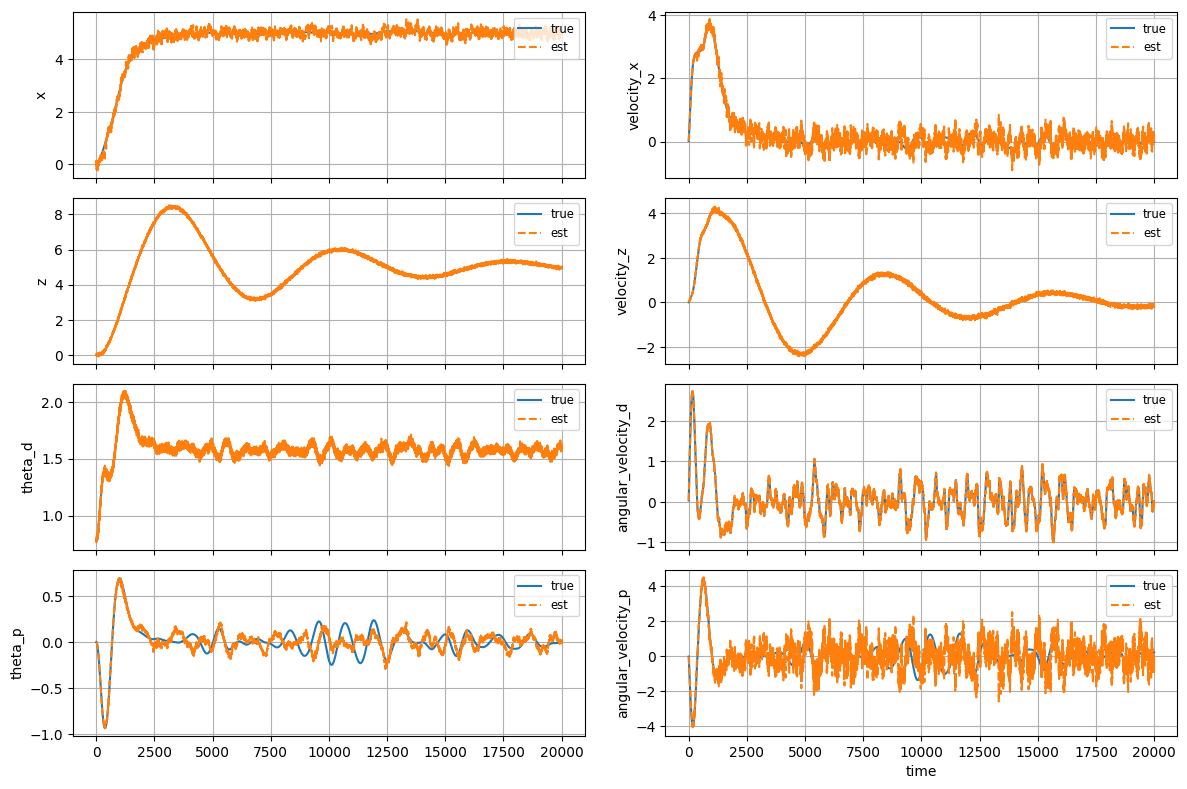

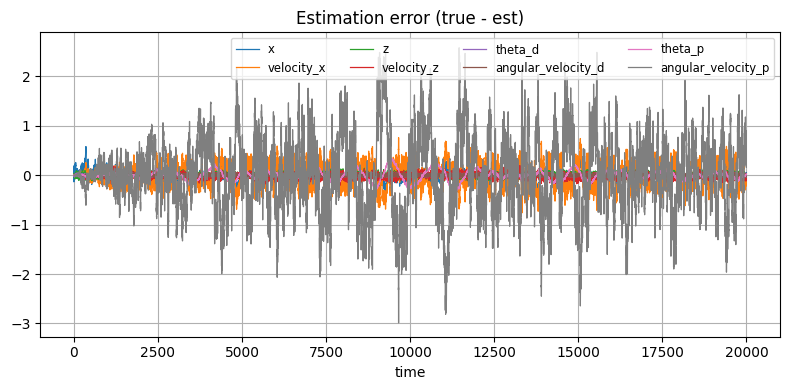

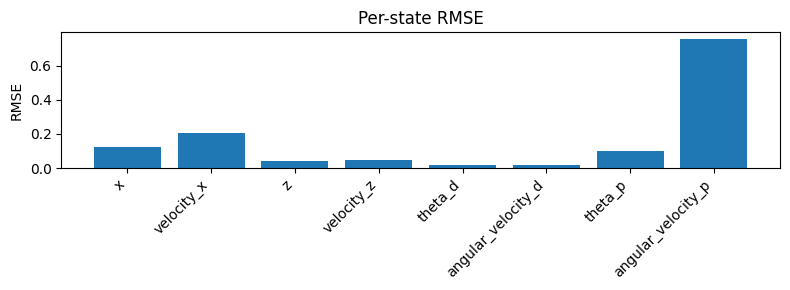

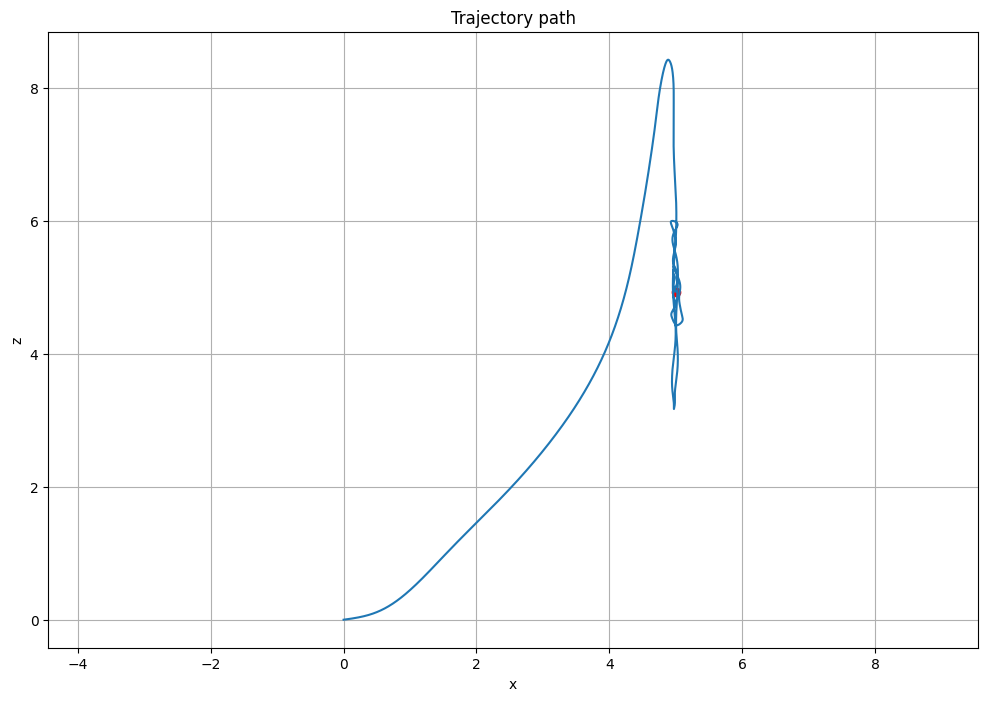

In [ ]:
hist, hist_hat, u_hist, t_terminate = baselineSimulation(Q, R, Q_noise, R_noise)

In [ ]:
compute_metrics(hist, u_ref_=u_ref_, u_hist=u_hist, t_settle=t_terminate)

Max package swing (degree):  39.81150426563668
Control Effort Motor 1: [4.37928378]
Control Effort Motor 2: [4.43946955]
Settling after: 5.258 seconds


### Failure case
- Overpenalize theta_p state over position states leads to aggressive control. This pushes the system outside the validity region of the linearized model, resulting in instability despite correct linearization and estimation.

In [ ]:
Q = np.diag([1, 0.5, 5, 1, 8, 1, 80, 10])
R = np.diag([0.5, 0.5])

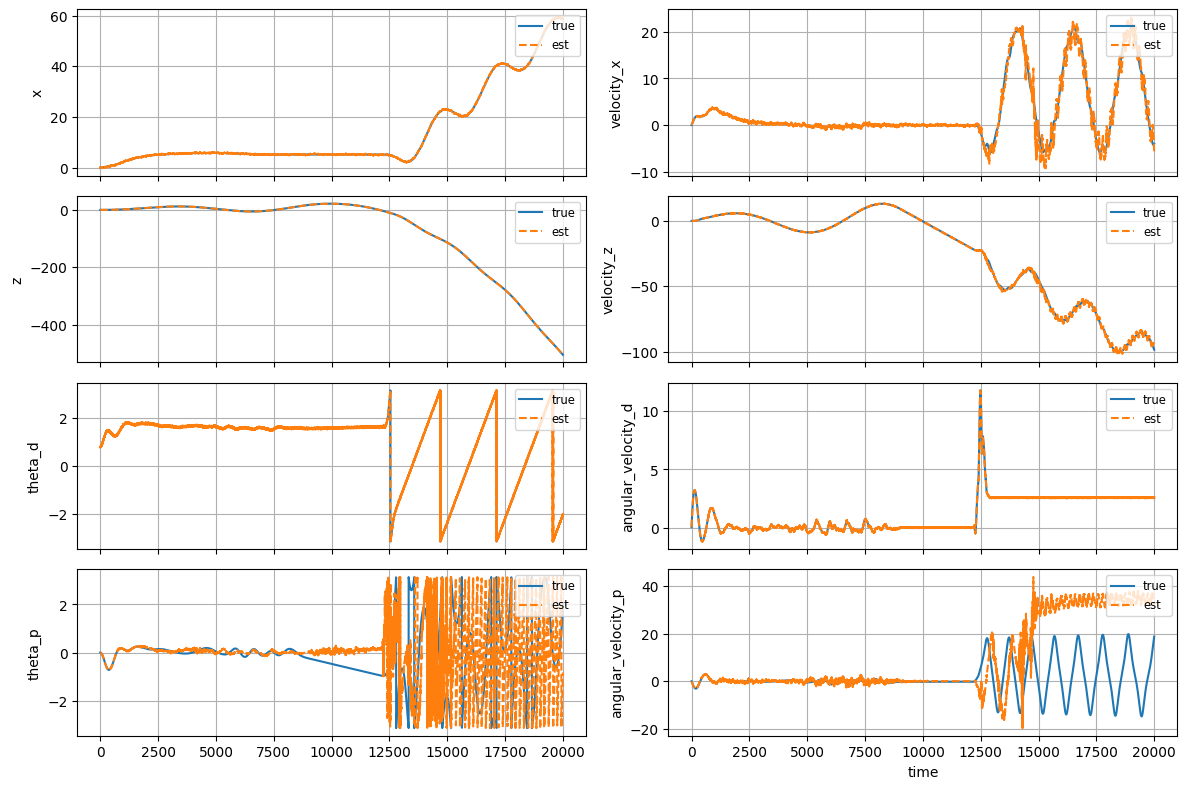

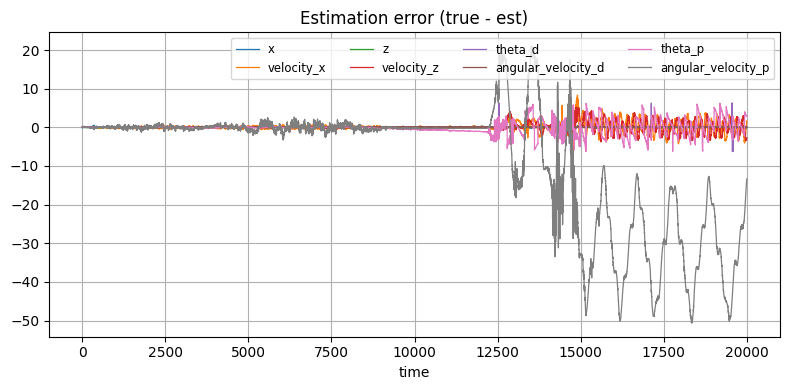

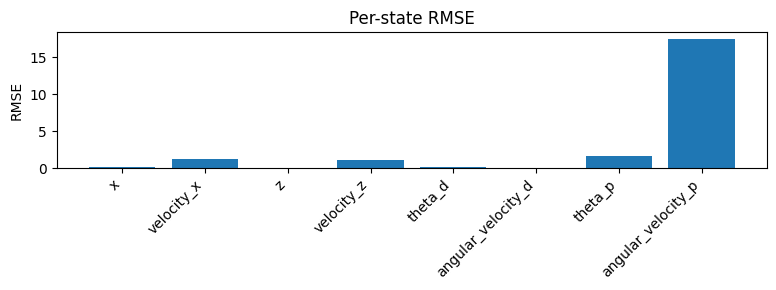

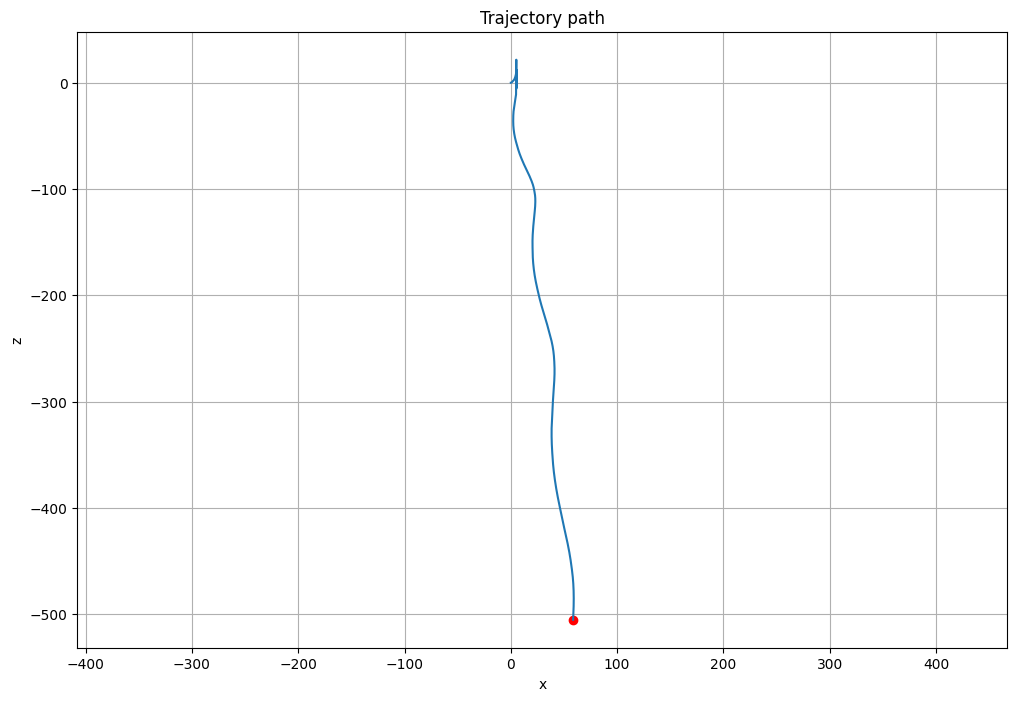

In [ ]:
hist, hist_hat, u_hist, t_terminate = baselineSimulation(Q, R, Q_noise, R_noise)

In [ ]:
compute_metrics(hist, u_ref_=u_ref_, u_hist=u_hist, t_settle=t_terminate)

Max package swing (degree):  179.99730329689325
Control Effort Motor 1: [39.21058755]
Control Effort Motor 2: [39.47316862]
The drone never settle


## Robustness test


### Gust F(t) = 0.1 * m_total * g *sin(2π·1.5t)

In [ ]:
def GustTestSimulation(Q, R, Q_noise, R_noise, Ki_, seed = 0, noise_multiplier = 1):
  rng = np.random.default_rng(seed=seed)
  lqr = lqr_controller(x_ref_, u_ref_, A, B, Ki_)
  Kr = lqr.get_Kr_(A, B, Q, R)
  x_ = np.array([0, 0, 0, 0, 0.25 * np.pi - 1.0e-3, 0, 0 + 1.0e-3, 0])
  x_hat_ = np.array(
      [0, 0, 0, 0, 0.25 * np.pi, 0, 0, 0]
  )  # initial estmated x
  P = np.eye(8) * 0.1
  integrator_limit = 10.0
  u_min = np.array([0.0, 0.0])
  u_max = np.array([1.5 * (m_d + m_p) * g, 1.5 * (m_d + m_p) * g])
  # main loop
  int_ = np.zeros_like(x_)
  steps = 20000
  hist = []
  u_hist = []
  hist_hat = []
  t_terminate = 0
  for step in range(steps):
    # in controller, it shouldnt have access to the world, it should only know what it can percieve by sensors
    int_ += (x_ref_ - x_hat_) * dt

    u_ = lqr.control_law(x_hat_, int_, Kr)
    u_ = np.clip(u_.flatten(), u_min, u_max)
    u_ = np.reshape(u_, (2, 1))


    dx_hat_pred = systemDynamics.dynamics(x_hat_, u_)
    x_hat_pred_ = x_hat_ + dx_hat_pred * dt
    Df_Dx, _ = systemDynamics.get_jacobian(x_hat_, u_)
    F = np.eye(8) + Df_Dx * dt

    P_pred = F @ P @ F.T + Q_noise

    # simulation, this is the real world
    dx_ = systemDynamics.dynamics(x_, u_)
    dx_[1] += 0.1 * np.sin(2 * np.pi * 1.5 * (step * dt))

    x_ += dx_ * dt

    # measure
    sigma = np.array([0.8, 0.1, 0.02])
    sigma_nx = noise_multiplier * sigma
    sensor_noise = rng.normal(0, sigma_nx)
    y_ = C @ x_ + sensor_noise
    y_err_ = y_ - (C @ x_hat_pred_)
    S = C @ P_pred @ C.T + R_noise
    Kf = P_pred @ C.T @ np.linalg.solve(S, np.eye(len(S)))

    x_hat_ = x_hat_pred_ + Kf @ y_err_
    P = (np.eye(8) - Kf @ C) @ P_pred

    # remember the past ahh code
    # karn dern tarng korng chun lae ther kue karn rien ruuuu ahh
    x, dx, z, dz, theta_d, dtheta_d, theta_p, dtheta_p = x_
    x_hat, _, z_hat, _, theta_d_hat, _, theta_p_hat, _ = x_hat_
    hist.append(x_.copy())
    hist_hat.append(x_hat_.copy())

    u_hist.append(u_)

    if compute_settle_time(x, z, dx, dz, theta_p, step) and t_terminate == 0:
      t_terminate = step

  hist = np.array(hist)
  hist_hat = np.array(hist_hat)

  hist[:, 4] = np.arctan2(np.sin(hist[:, 4]), np.cos(hist[:, 4]))
  hist[:, 6] = np.arctan2(np.sin(hist[:, 6]), np.cos(hist[:, 6]))

  hist_hat[:, 4] = np.arctan2(np.sin(hist_hat[:, 4]), np.cos(hist_hat[:, 4]))
  hist_hat[:, 6] = np.arctan2(np.sin(hist_hat[:, 6]), np.cos(hist_hat[:, 6]))


  states_name = [
      "x",
      "velocity_x",
      "z",
      "velocity_z",
      "theta_d",
      "angular_velocity_d",
      "theta_p",
      "angular_velocity_p",
  ]

  plot_state_history(hist, hist_hat, state_names=states_name, plot_error=True)

  return hist, hist_hat, u_hist, t_terminate

In [ ]:
Q_noise = np.eye(8) * 0.001
R_noise = np.diag([0.8**2, 0.1**2, 0.02**2])

In [ ]:
Q = np.diag([50, 30, 50, 20, 30, 10, 60, 10])
R = np.diag([0.1, 0.1])

In [ ]:
Ki

array([[0, 0, 5, 0, 0, 0, 0, 0],
       [0, 0, 5, 0, 0, 0, 0, 0]])

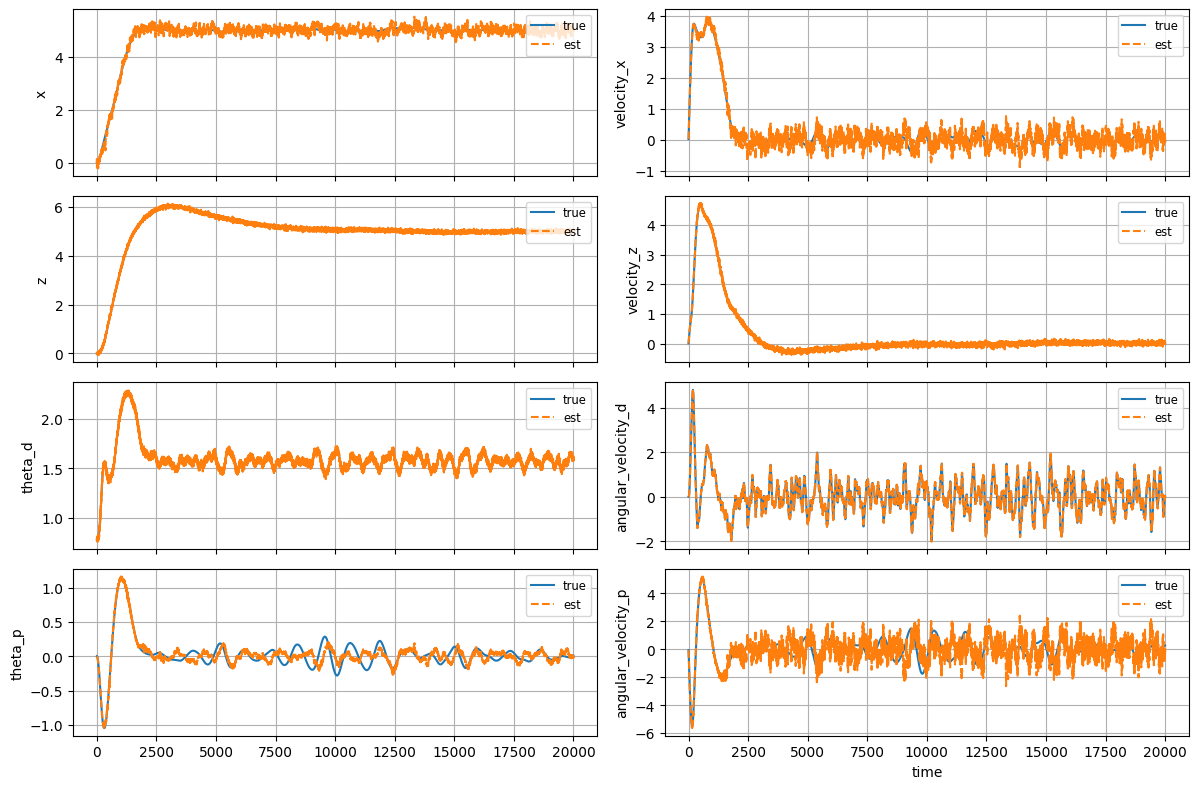

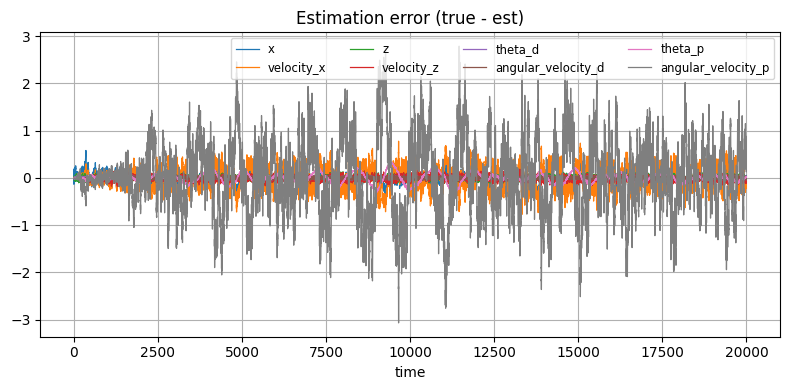

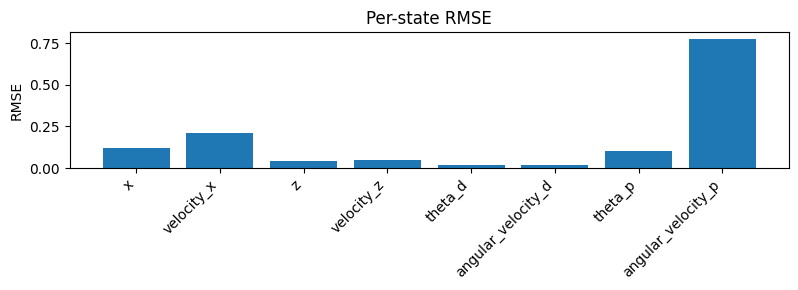

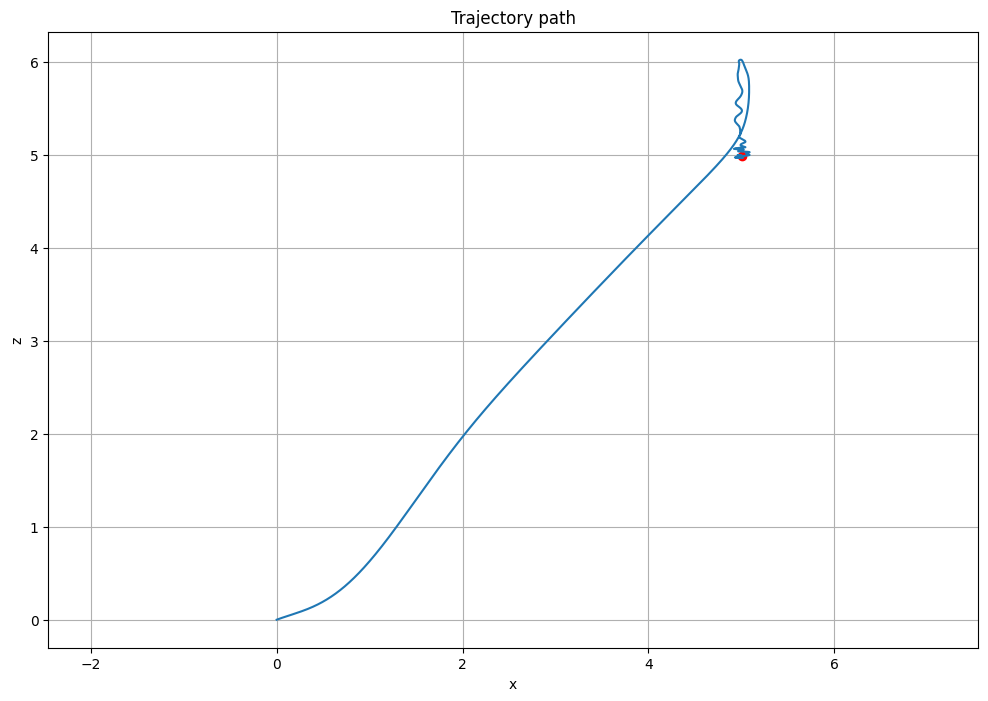

In [ ]:
hist, hist_hat, u_hist, t_terminate = GustTestSimulation(Q, R, Q_noise, R_noise, Ki, noise_multiplier=1)

In [ ]:
compute_metrics(hist, u_ref_, u_hist, t_terminate)

Max package swing (degree):  64.91850800077341
Control Effort Motor 1: [7.45489251]
Control Effort Motor 2: [7.46984197]
Settling after: 11.431000000000001 seconds


### Sensor noise increase

In [ ]:
def NoiseTestSimulation(Q, R, Q_noise, R_noise, Ki_, seed = 0, noise_multiplier = 2):
  rng = np.random.default_rng(seed=seed)
  lqr = lqr_controller(x_ref_, u_ref_, A, B, Ki_)
  Kr = lqr.get_Kr_(A, B, Q, R)
  x_ = np.array([0, 0, 0, 0, 0.25 * np.pi - 1.0e-3, 0, 0 + 1.0e-3, 0])
  x_hat_ = np.array(
      [0, 0, 0, 0, 0.25 * np.pi, 0, 0, 0]
  )  # initial estmated x
  P = np.eye(8) * 0.1
  integrator_limit = 10.0
  u_min = np.array([0.0, 0.0])
  u_max = np.array([1.5 * (m_d + m_p) * g, 1.5 * (m_d + m_p) * g])
  # main loop
  int_ = np.zeros_like(x_)
  steps = 20000
  hist = []
  u_hist = []
  hist_hat = []
  t_terminate = 0
  for step in range(steps):
    # in controller, it shouldnt have access to the world, it should only know what it can percieve by sensors
    int_ += (x_ref_ - x_hat_) * dt

    u_ = lqr.control_law(x_hat_, int_, Kr)
    u_ = np.clip(u_.flatten(), u_min, u_max)
    u_ = np.reshape(u_, (2, 1))


    dx_hat_pred = systemDynamics.dynamics(x_hat_, u_)
    x_hat_pred_ = x_hat_ + dx_hat_pred * dt
    Df_Dx, _ = systemDynamics.get_jacobian(x_hat_, u_)
    F = np.eye(8) + Df_Dx * dt

    P_pred = F @ P @ F.T + Q_noise

    # simulation, this is the real world
    dx_ = systemDynamics.dynamics(x_, u_)
    # dx_[1] += 0.1 * np.sin(2 * np.pi * 1.5 * (step * dt))

    x_ += dx_ * dt

    # measure
    sigma = np.array([0.8, 0.1, 0.02])
    sigma_nx = noise_multiplier * sigma
    sensor_noise = rng.normal(0, sigma_nx)
    y_ = C @ x_ + sensor_noise
    y_err_ = y_ - (C @ x_hat_pred_)
    S = C @ P_pred @ C.T + R_noise
    Kf = P_pred @ C.T @ np.linalg.solve(S, np.eye(len(S)))

    x_hat_ = x_hat_pred_ + Kf @ y_err_
    P = (np.eye(8) - Kf @ C) @ P_pred

    # remember the past ahh code
    # karn dern tarng korng chun lae ther kue karn rien ruuuu ahh
    x, dx, z, dz, theta_d, dtheta_d, theta_p, dtheta_p = x_
    x_hat, _, z_hat, _, theta_d_hat, _, theta_p_hat, _ = x_hat_
    hist.append(x_.copy())
    hist_hat.append(x_hat_.copy())

    u_hist.append(u_)

    if compute_settle_time(x, z, dx, dz, theta_p, step) and t_terminate == 0:
      t_terminate = step

  hist = np.array(hist)
  hist_hat = np.array(hist_hat)

  hist[:, 4] = np.arctan2(np.sin(hist[:, 4]), np.cos(hist[:, 4]))
  hist[:, 6] = np.arctan2(np.sin(hist[:, 6]), np.cos(hist[:, 6]))

  hist_hat[:, 4] = np.arctan2(np.sin(hist_hat[:, 4]), np.cos(hist_hat[:, 4]))
  hist_hat[:, 6] = np.arctan2(np.sin(hist_hat[:, 6]), np.cos(hist_hat[:, 6]))


  states_name = [
      "x",
      "velocity_x",
      "z",
      "velocity_z",
      "theta_d",
      "angular_velocity_d",
      "theta_p",
      "angular_velocity_p",
  ]

  plot_state_history(hist, hist_hat, state_names=states_name, plot_error=True)

  return hist, hist_hat, u_hist, t_terminate

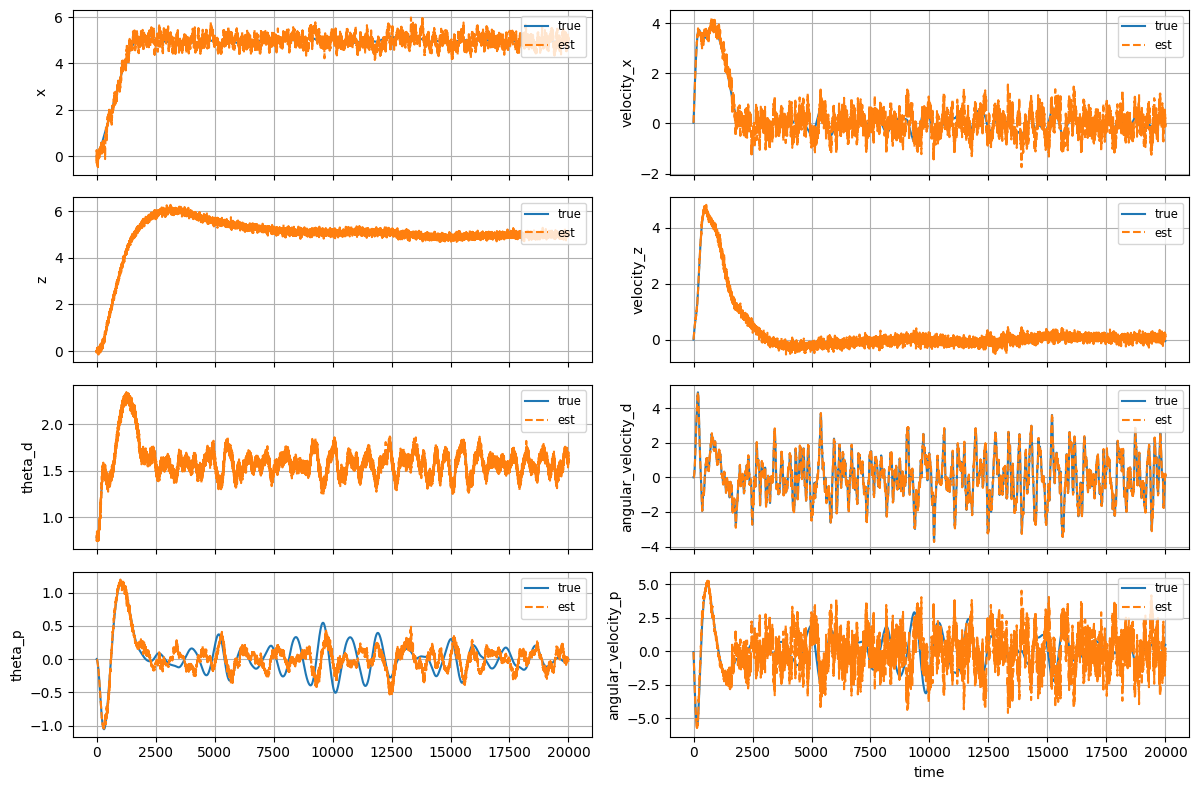

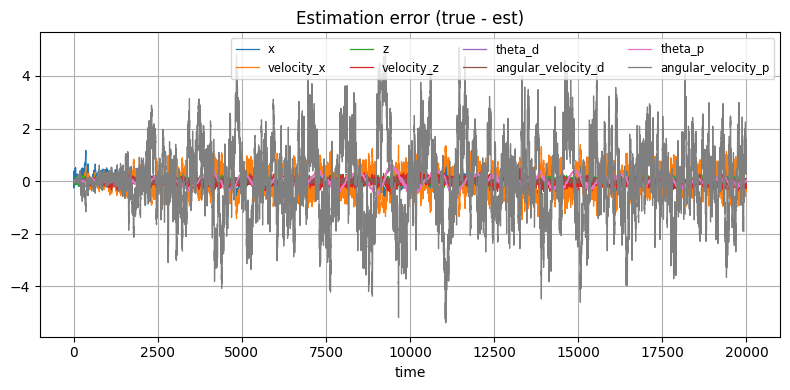

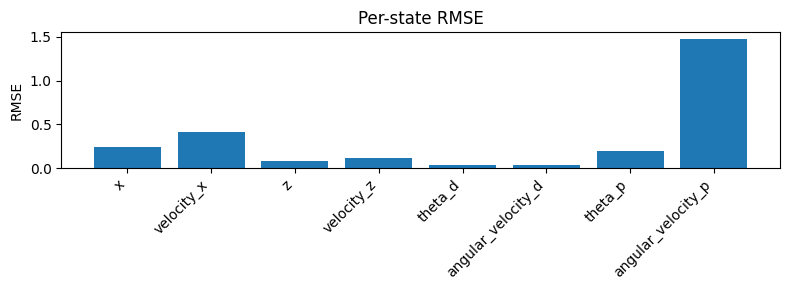

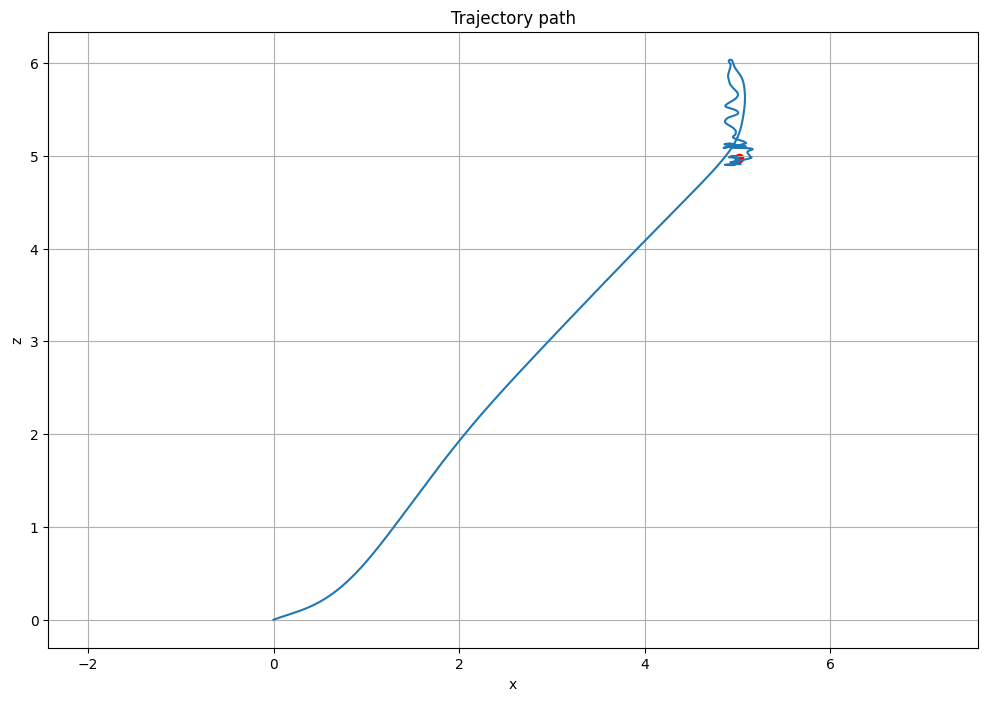

In [ ]:
hist, hist_hat, u_hist, t_terminate = NoiseTestSimulation(Q, R, Q_noise, R_noise, Ki, noise_multiplier=2)

In [ ]:
compute_metrics(hist, u_ref_, u_hist, t_terminate)

Max package swing (degree):  65.77895210530531
Control Effort Motor 1: [13.21638327]
Control Effort Motor 2: [13.2817721]
Settling after: 16.281 seconds


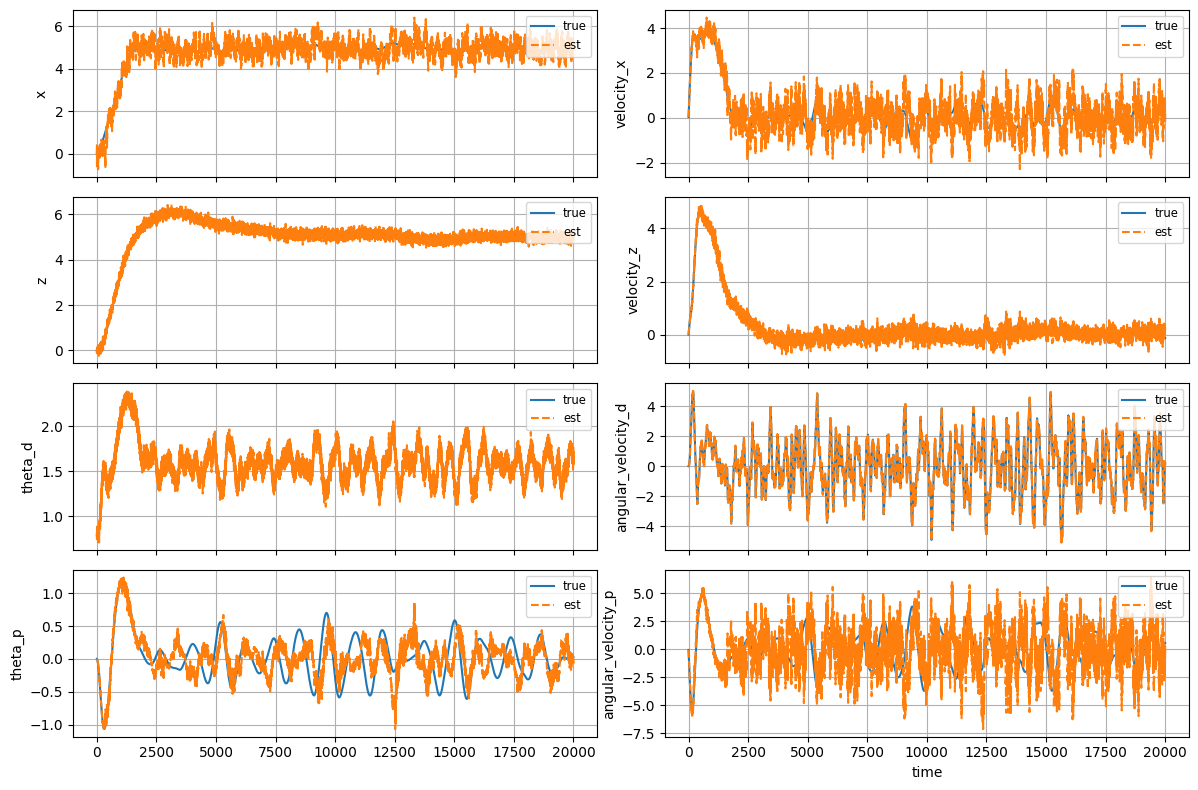

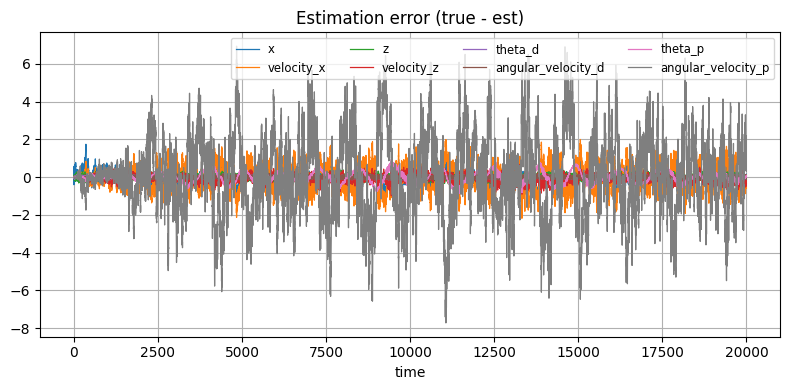

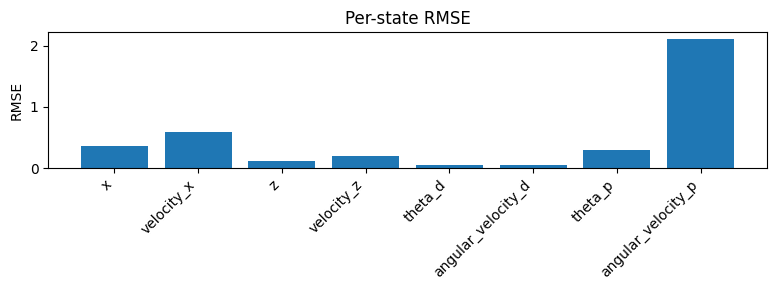

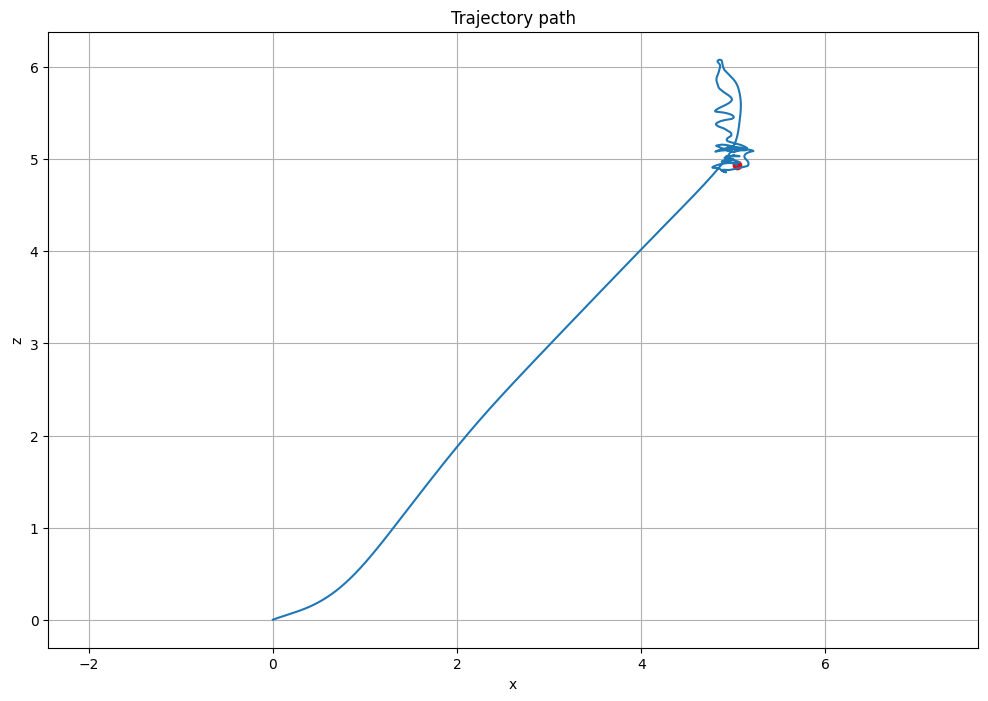

In [ ]:
hist, hist_hat, u_hist, t_terminate = NoiseTestSimulation(Q, R, Q_noise, R_noise, Ki, noise_multiplier=3)

In [ ]:
compute_metrics(hist, u_ref_, u_hist, t_terminate)

Max package swing (degree):  66.97846057547555
Control Effort Motor 1: [18.20949201]
Control Effort Motor 2: [18.44967125]
Settling after: 16.342 seconds


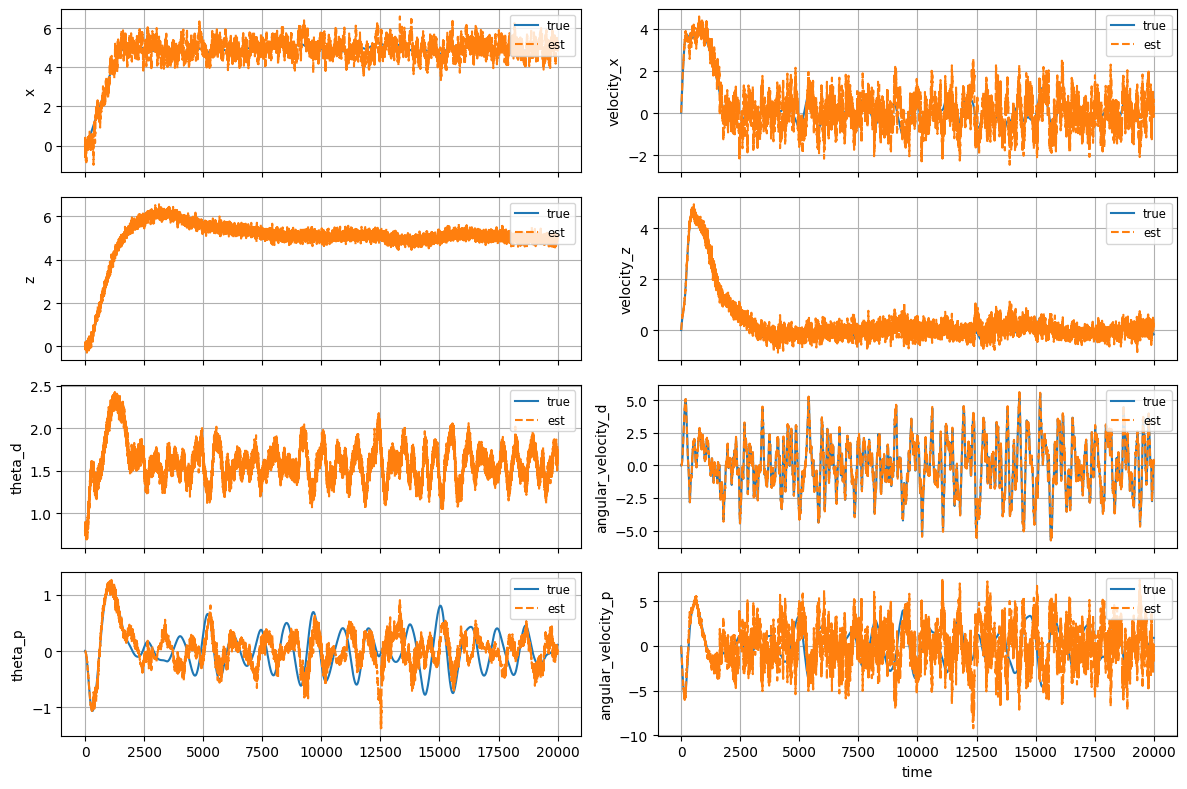

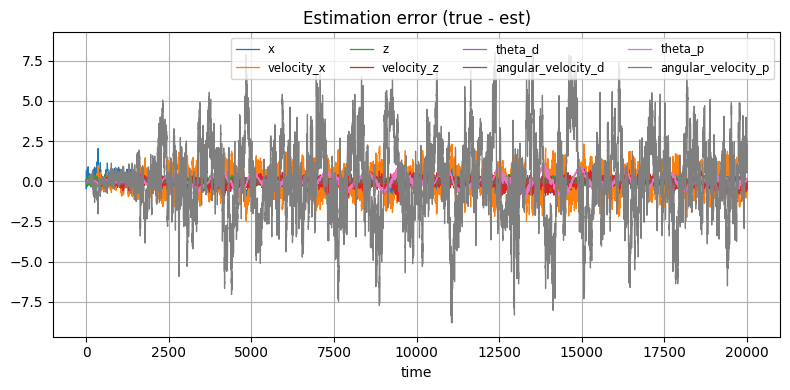

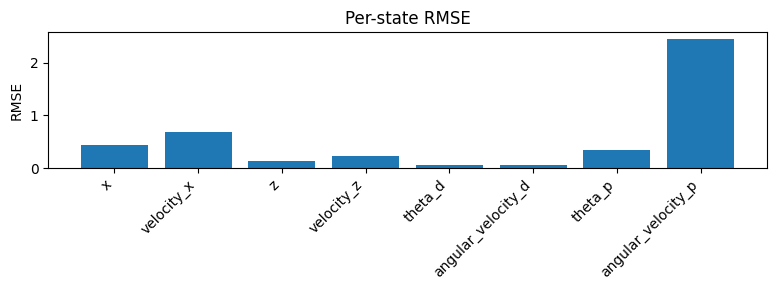

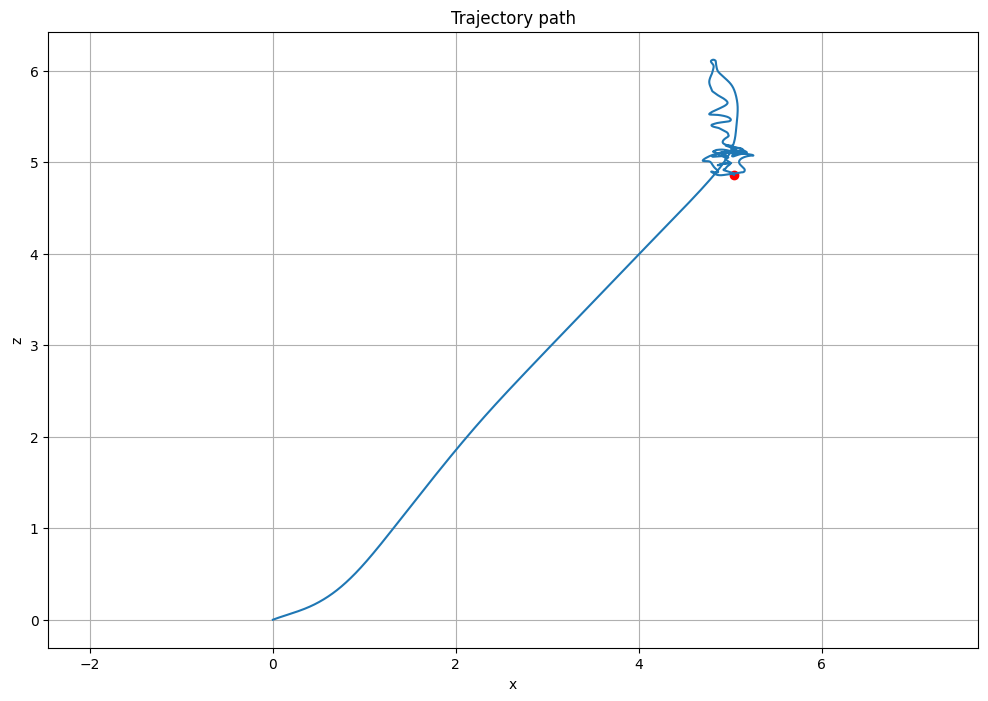

In [ ]:
hist, hist_hat, u_hist, t_terminate = NoiseTestSimulation(Q, R, Q_noise, R_noise, Ki, noise_multiplier=3.5)

In [ ]:
compute_metrics(hist, u_ref_, u_hist, t_terminate)

Max package swing (degree):  67.65695160630084
Control Effort Motor 1: [20.41500116]
Control Effort Motor 2: [20.76176832]
The drone never settle


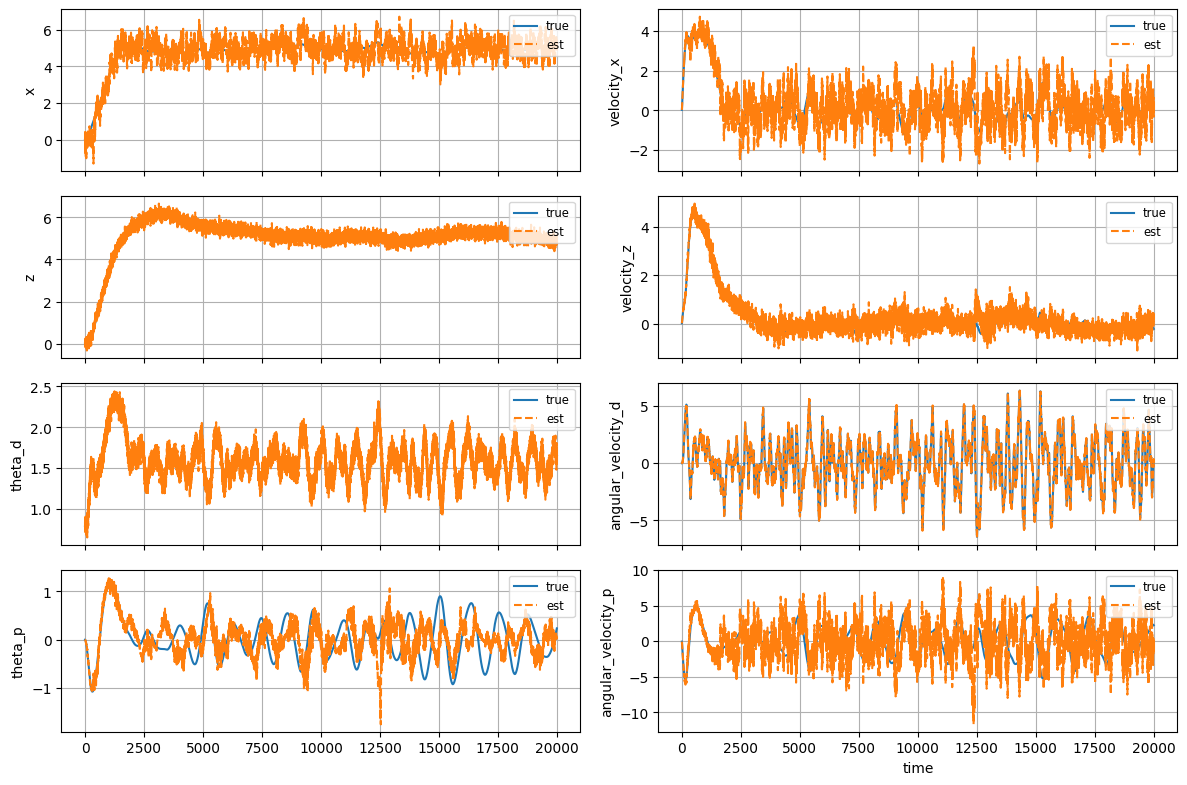

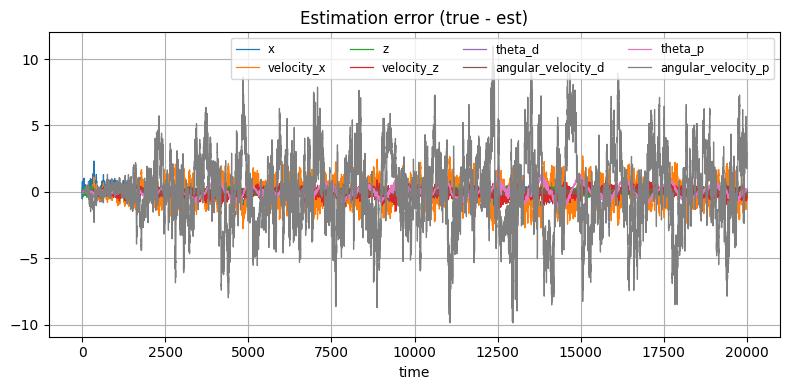

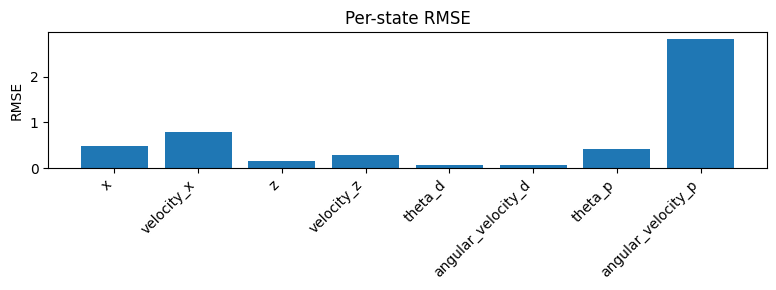

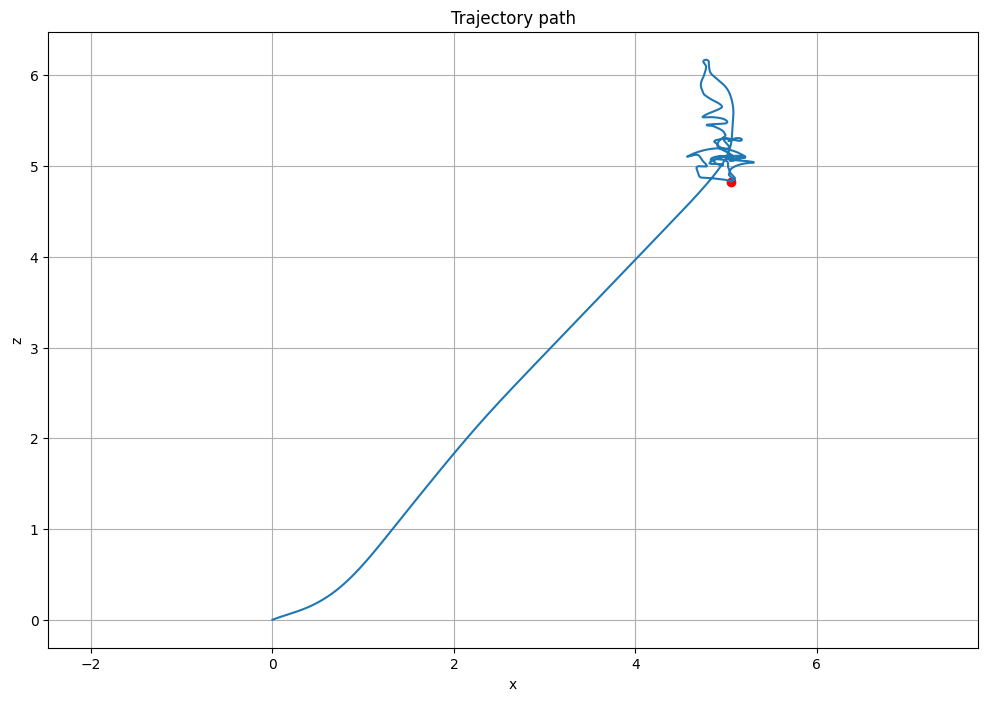

In [ ]:
hist, hist_hat, u_hist, t_terminate = NoiseTestSimulation(Q, R, Q_noise, R_noise, Ki, noise_multiplier=4)

In [ ]:
compute_metrics(hist, u_ref_, u_hist, t_terminate)

Max package swing (degree):  68.37264148916749
Control Effort Motor 1: [22.44804497]
Control Effort Motor 2: [22.81308394]
The drone never settle


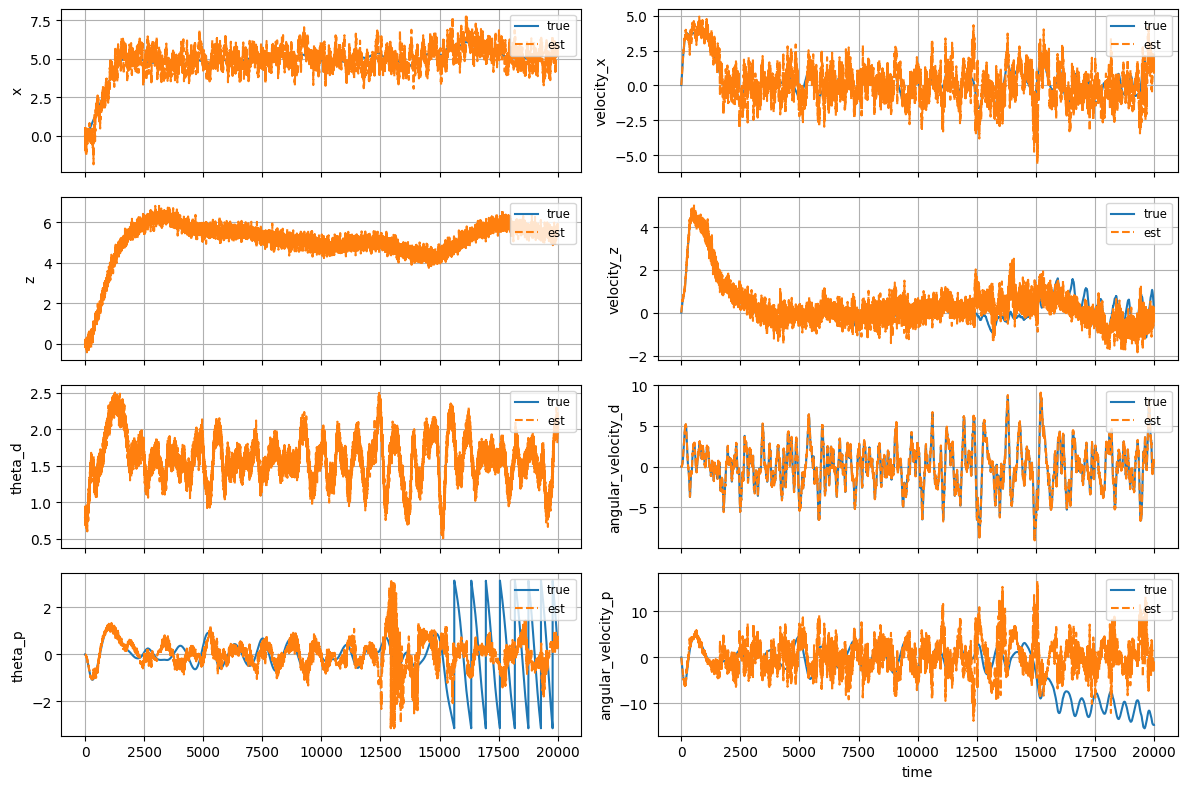

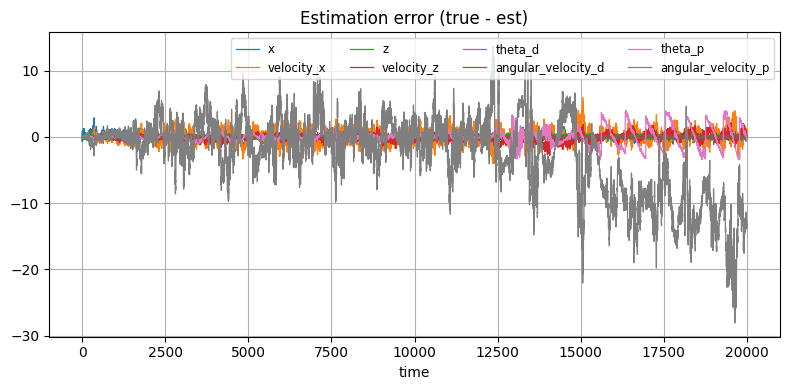

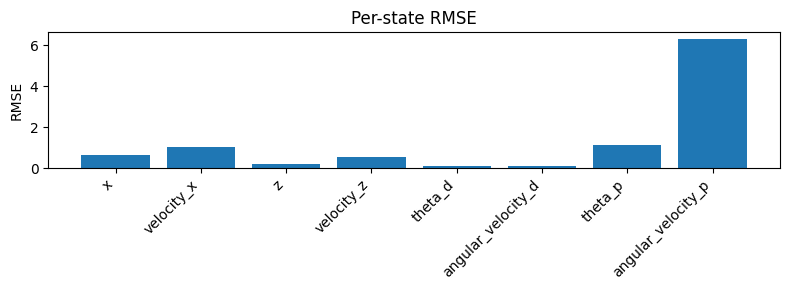

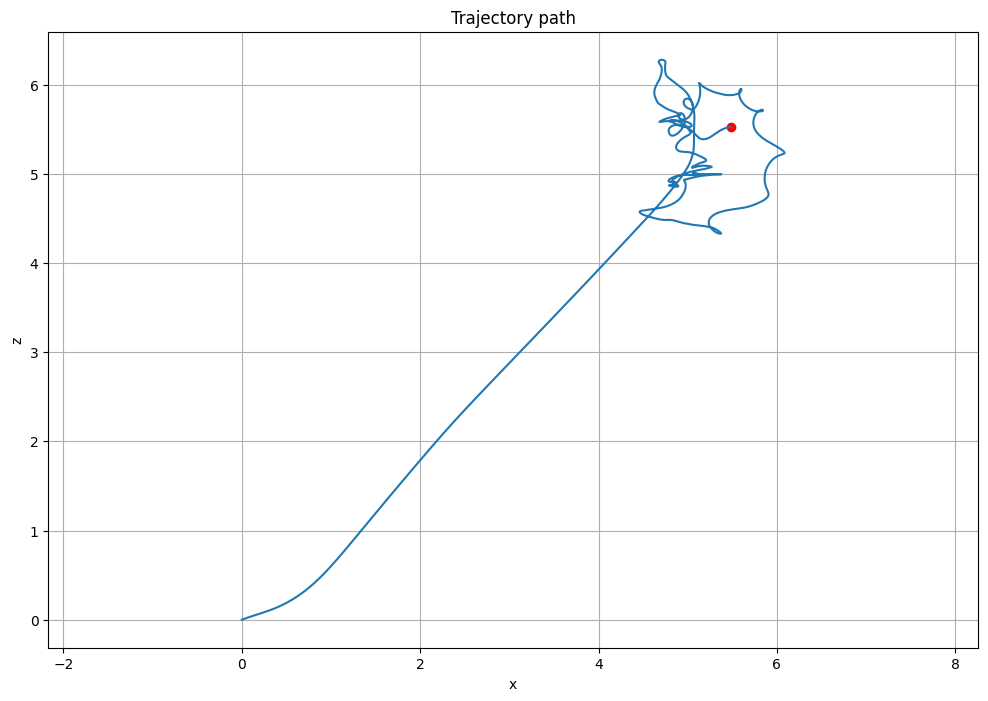

In [ ]:
hist, hist_hat, u_hist, t_terminate = NoiseTestSimulation(Q, R, Q_noise, R_noise, Ki, noise_multiplier=5)

In [ ]:
compute_metrics(hist, u_ref_, u_hist, t_terminate)

Max package swing (degree):  179.9884443351833
Control Effort Motor 1: [25.19107391]
Control Effort Motor 2: [25.36533696]
The drone never settle


Add integral term to x-axis because gust disturbance comes in x disrection

In [ ]:
Ki_xz = np.array([[0.5, 0, 5, 0, 0, 0, 0, 0], [0.5, 0, 5, 0, 0, 0, 0, 0]])

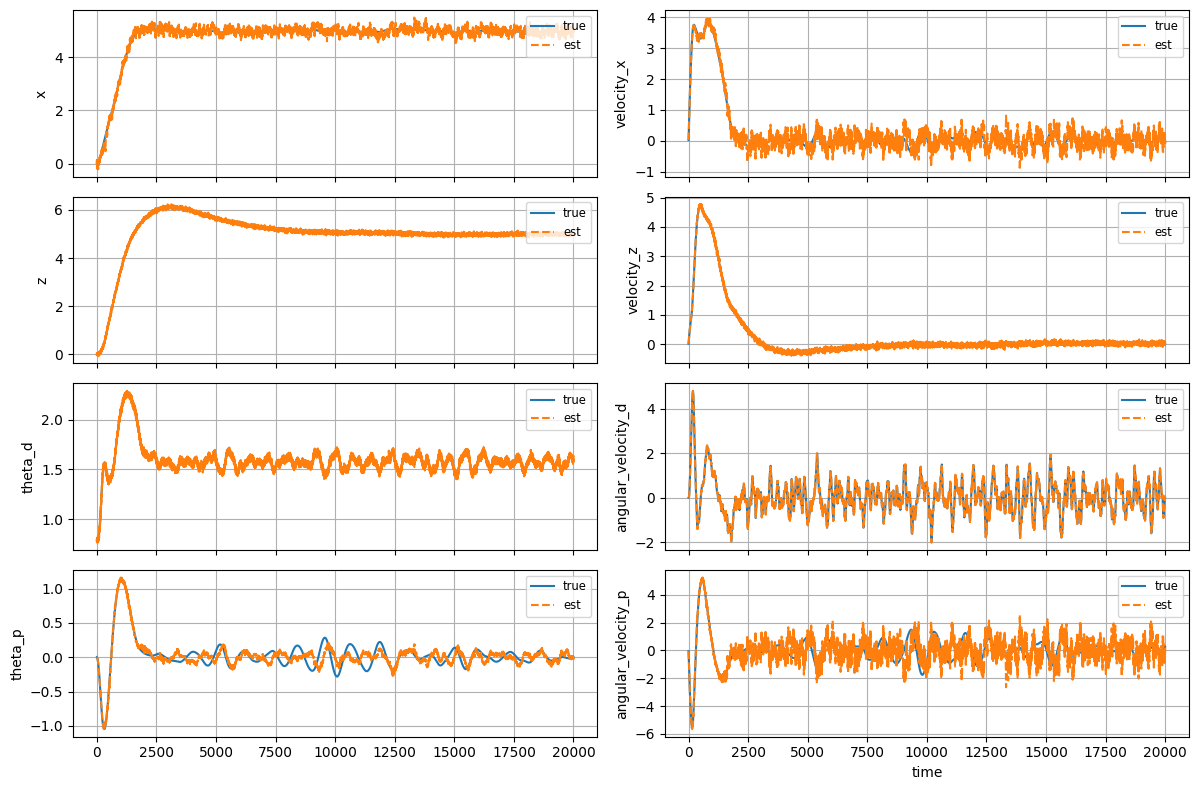

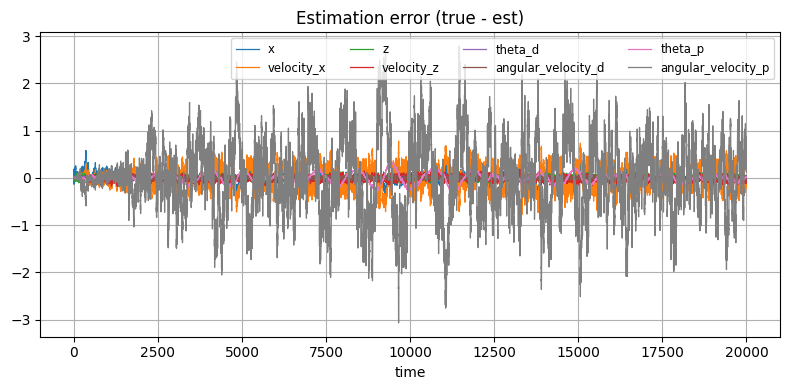

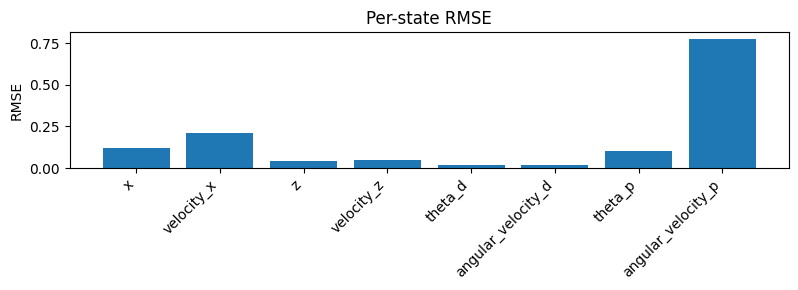

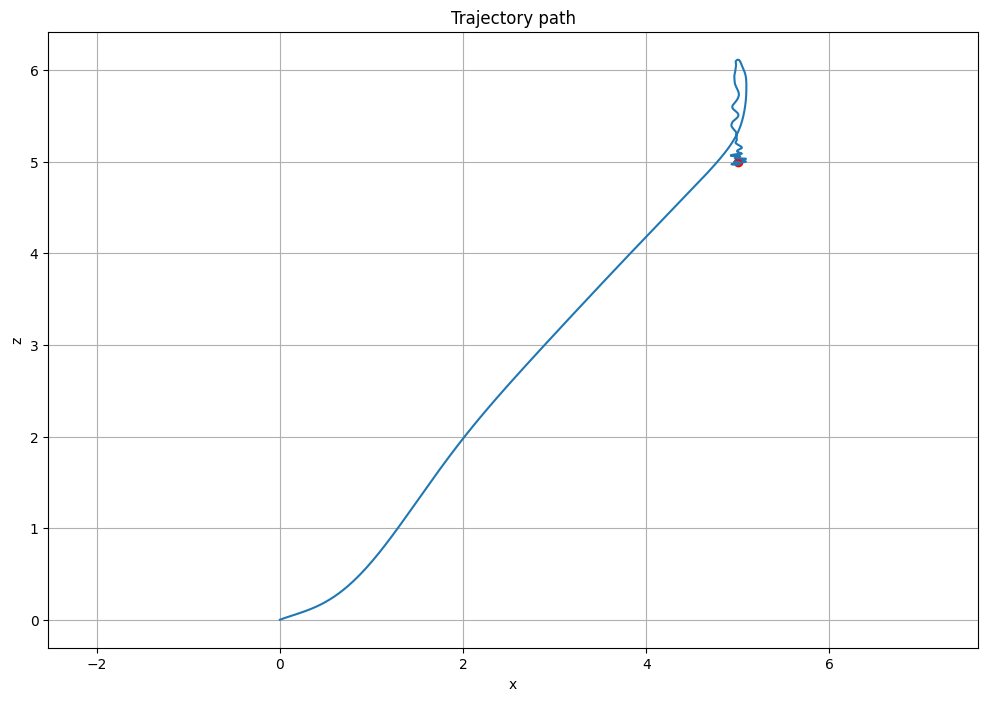

In [ ]:
hist, hist_hat, u_hist, t_terminate = GustTestSimulation(Q, R, Q_noise, R_noise, Ki_xz, noise_multiplier=1)

In [ ]:
compute_metrics(hist, u_ref_, u_hist, t_terminate)

Max package swing (degree):  64.8475682660599
Control Effort Motor 1: [7.47054672]
Control Effort Motor 2: [7.47696216]
Settling after: 11.486 seconds


## Sensivity study

In [ ]:
# This is baseline Q
print("Q_baseline")
print(Q)
print("R_baseline")
print(R)

Q_baseline
[[50  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0]
 [ 0  0  0  0 30  0  0  0]
 [ 0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 60  0]
 [ 0  0  0  0  0  0  0 10]]
R_baseline
[[0.1 0. ]
 [0.  0.1]]


In [ ]:
Q_theta_values = [20, 60, 120]
R_values = [0.05, 0.1, 0.2]

In [ ]:
def sensitivity(Q_varies_list, Q_varies_idx, Q_baseline, R_values):
  results = []
  for Qtp in Q_varies_list:
    for Rval in R_values:
      Q = Q_baseline.copy()
      Q[Q_varies_idx, Q_varies_idx] = Qtp
      R = np.diag([Rval, Rval])

      hist, hist_hat, u_hist, t_settle = baselineSimulation(
            Q, R, Q_noise, R_noise
      )
      x_hist = hist[:, 0]
      z_hist = hist[:, 2]
      theta_p = hist[:, 6]

      rmse_x = np.sqrt(np.mean((x_hist - x_ref)**2))
      rmse_z = np.sqrt(np.mean((z_hist - z_ref)**2))
      max_swing = np.max(np.abs(theta_p))

      u_hist = np.array(u_hist).reshape(-1, 2)
      u_bar = np.array([0.5*M*g, 0.5*M*g])
      mean_effort = np.mean(np.abs(u_hist - u_bar))

      results.append({
          "Q_theta_p": Qtp,
          "R": Rval,
          "rmse_x": rmse_x,
          "rmse_z": rmse_z,
          "max_theta_p": max_swing,
          "mean_effort": mean_effort,
          "settling_time": t_settle * dt if t_settle > 0 else None
        })

  return results

In [ ]:
Q

array([[50,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 30,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 50,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 20,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 30,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 60,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10]])

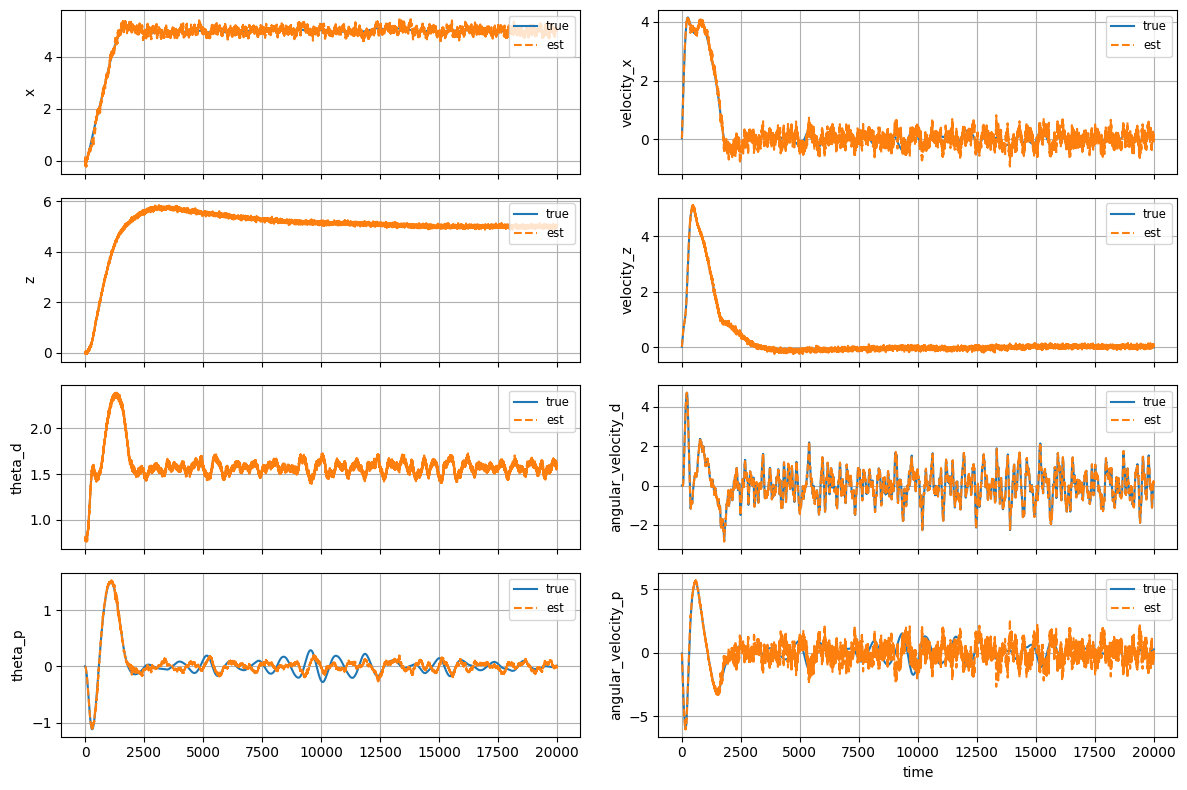

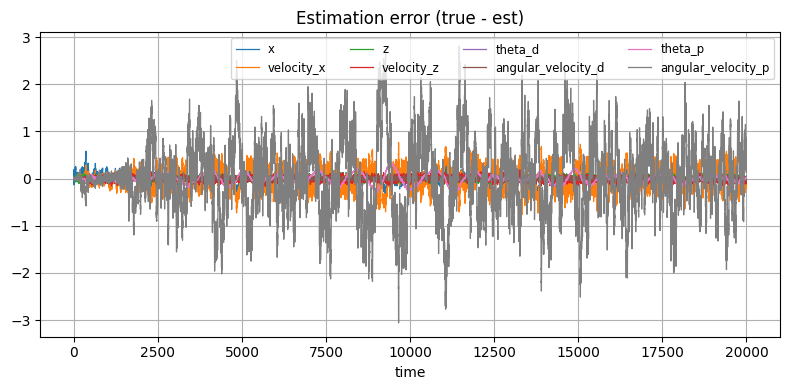

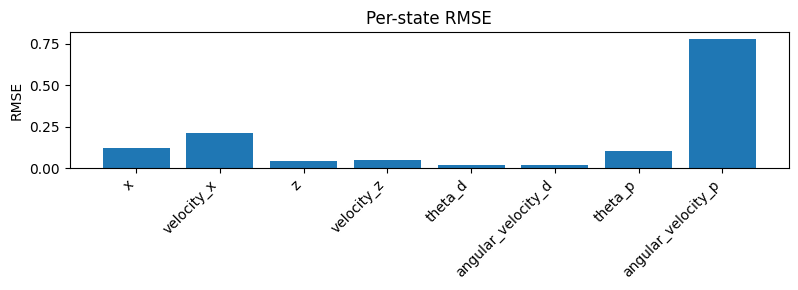

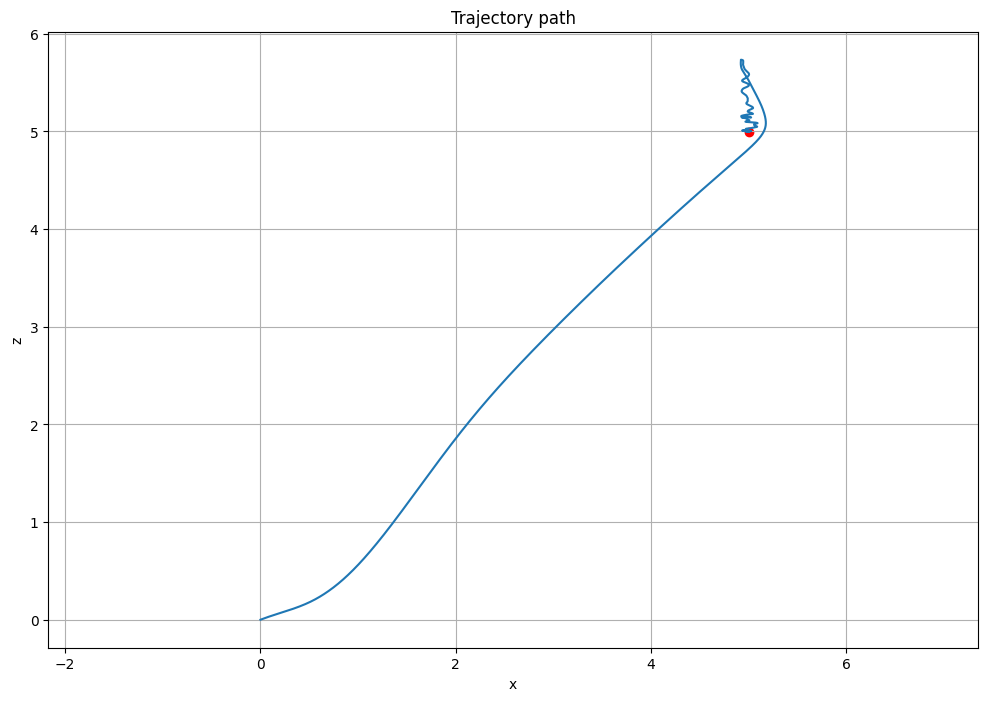

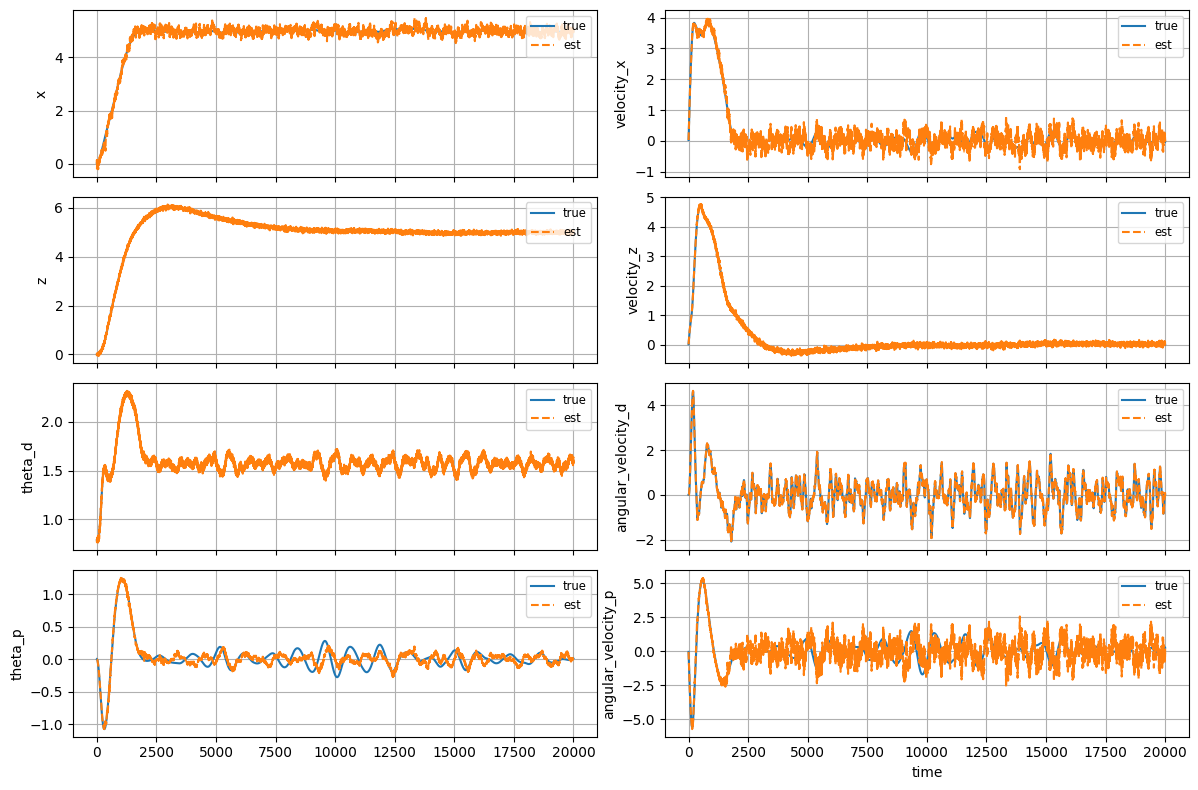

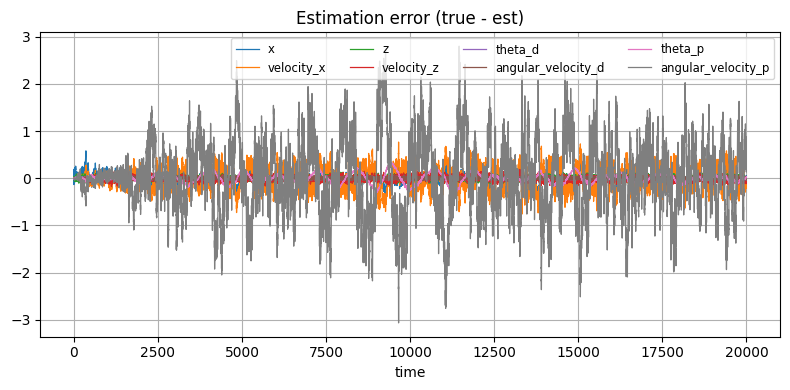

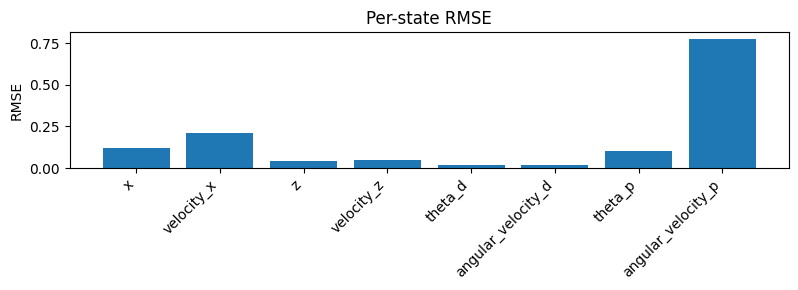

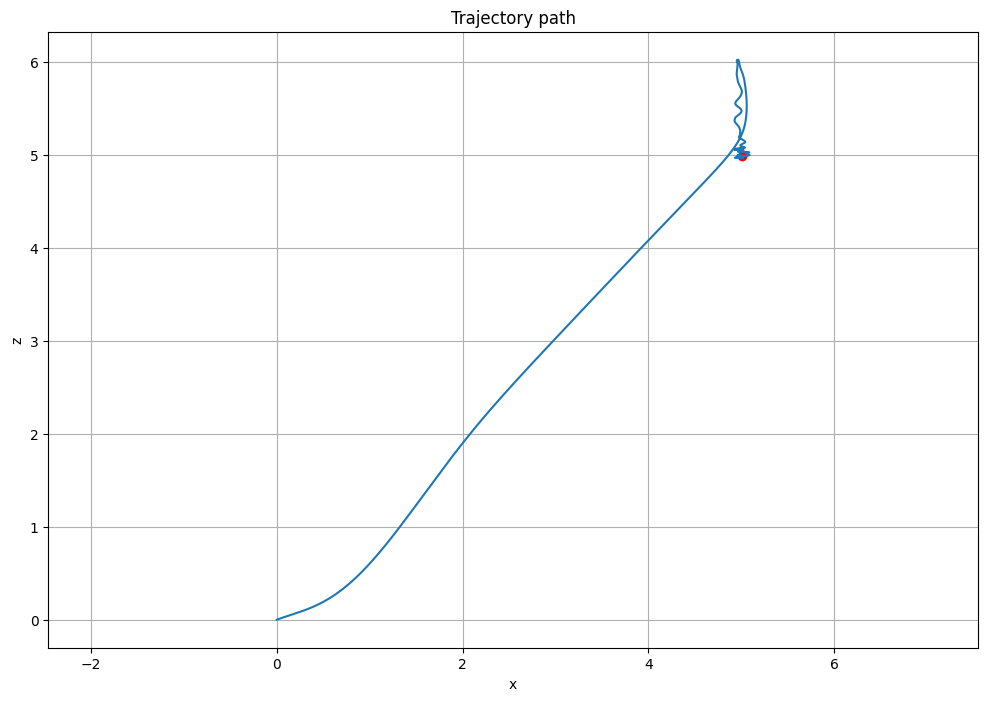

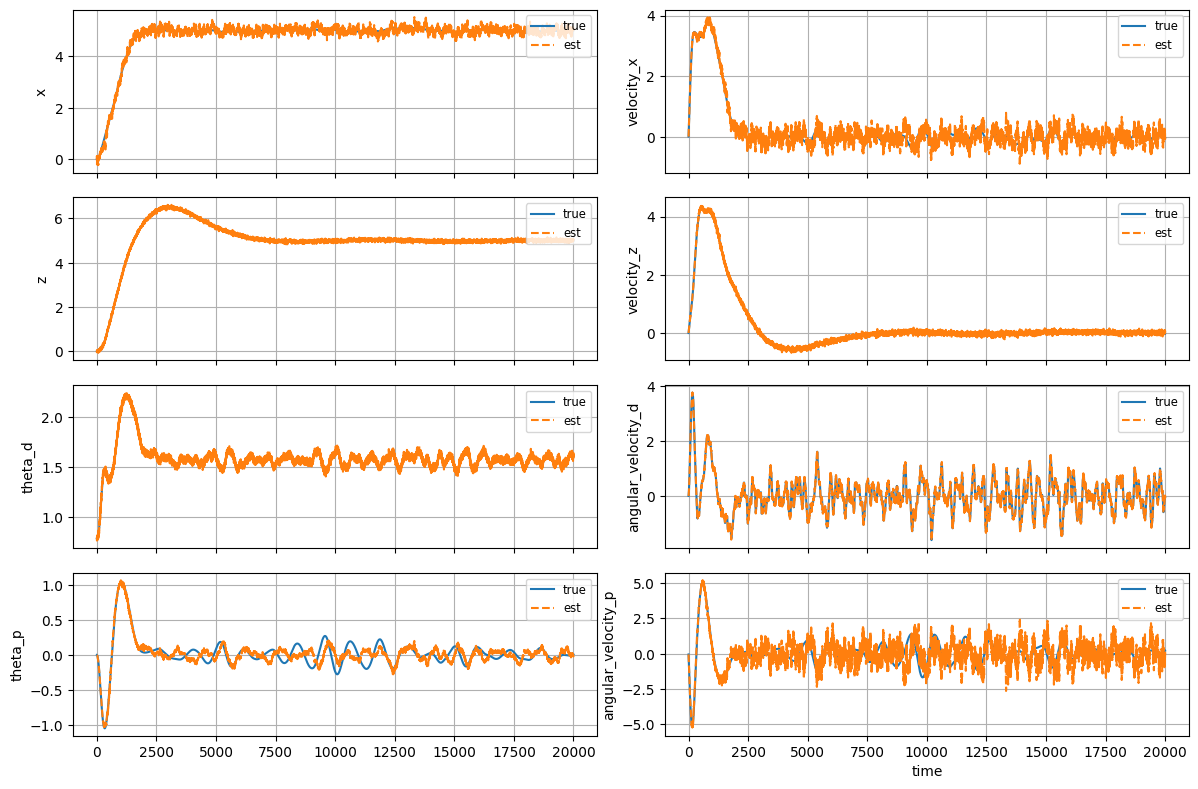

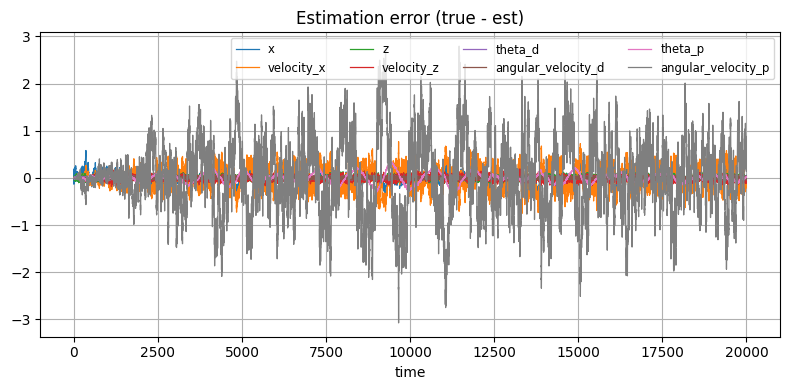

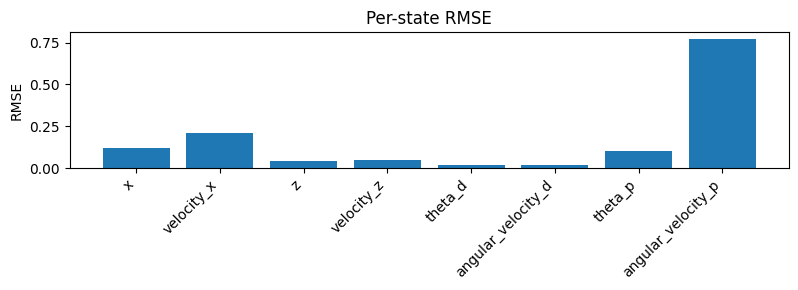

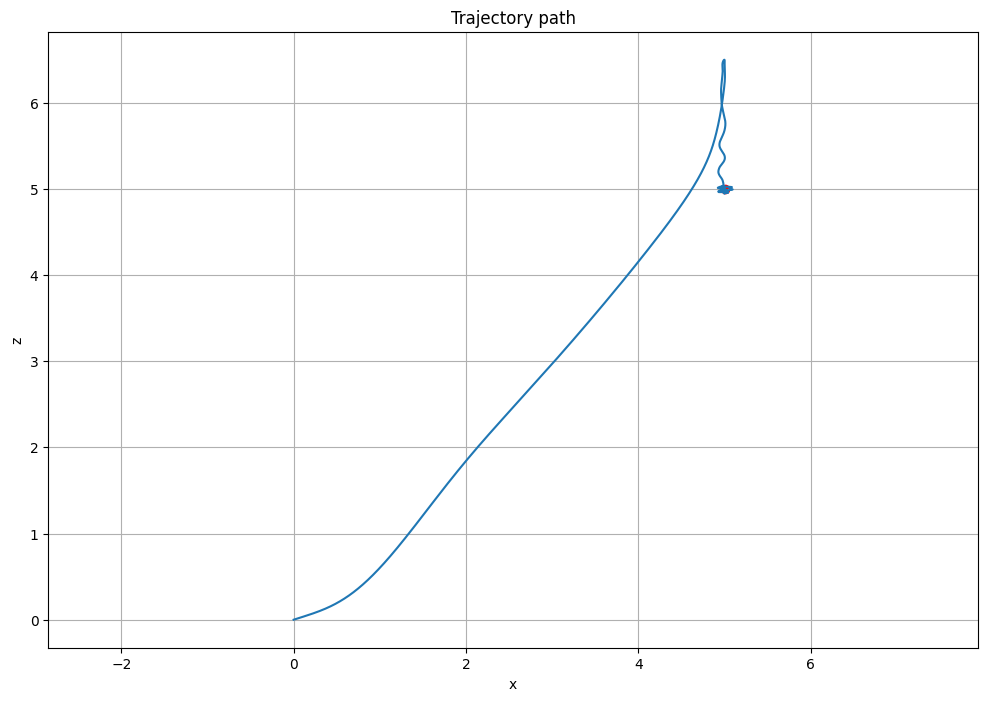

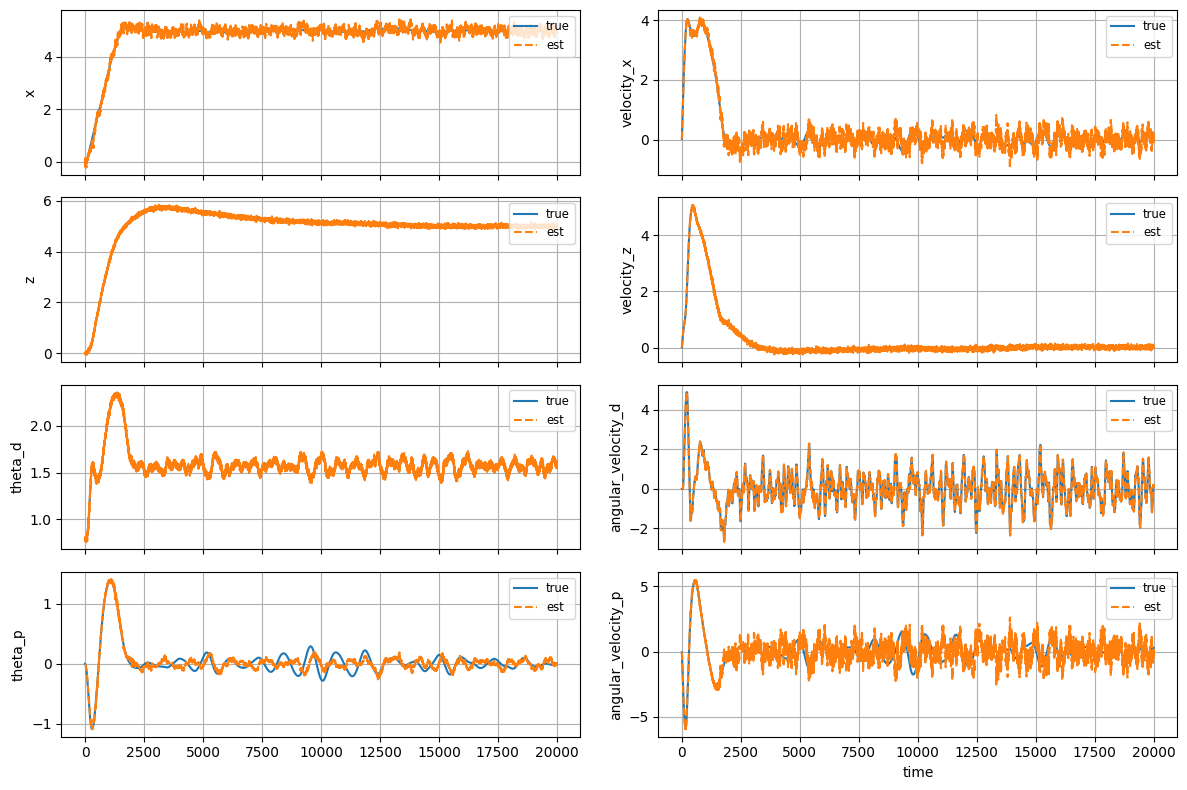

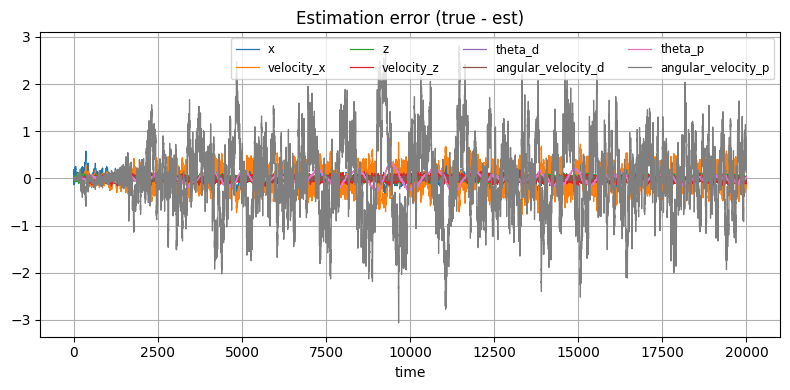

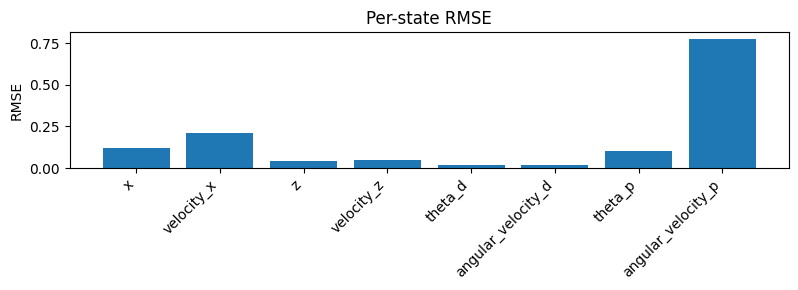

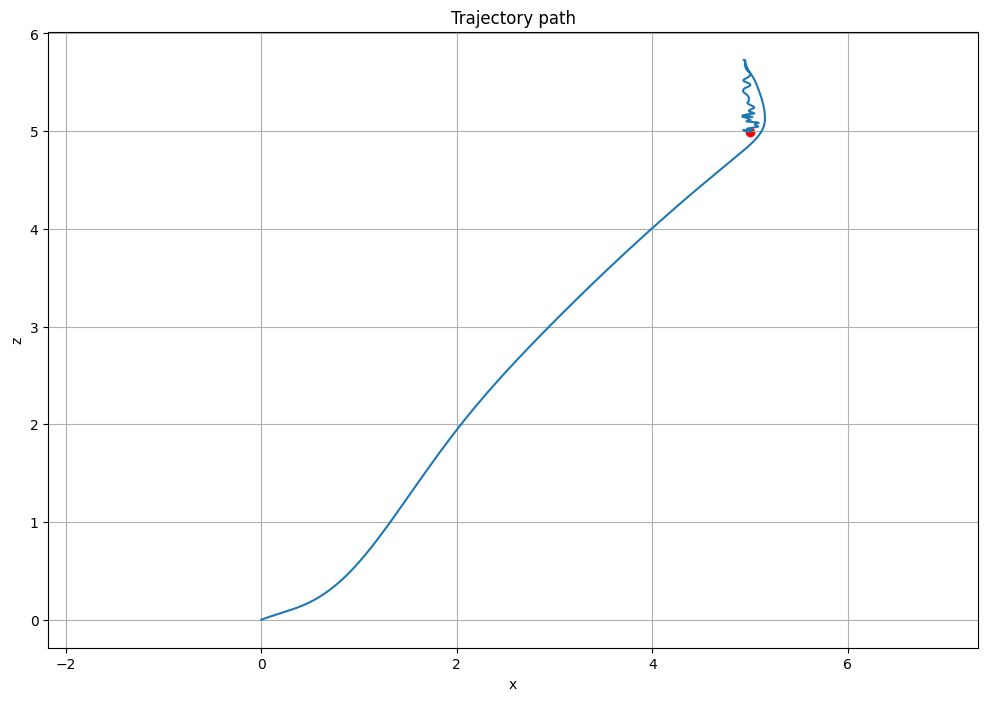

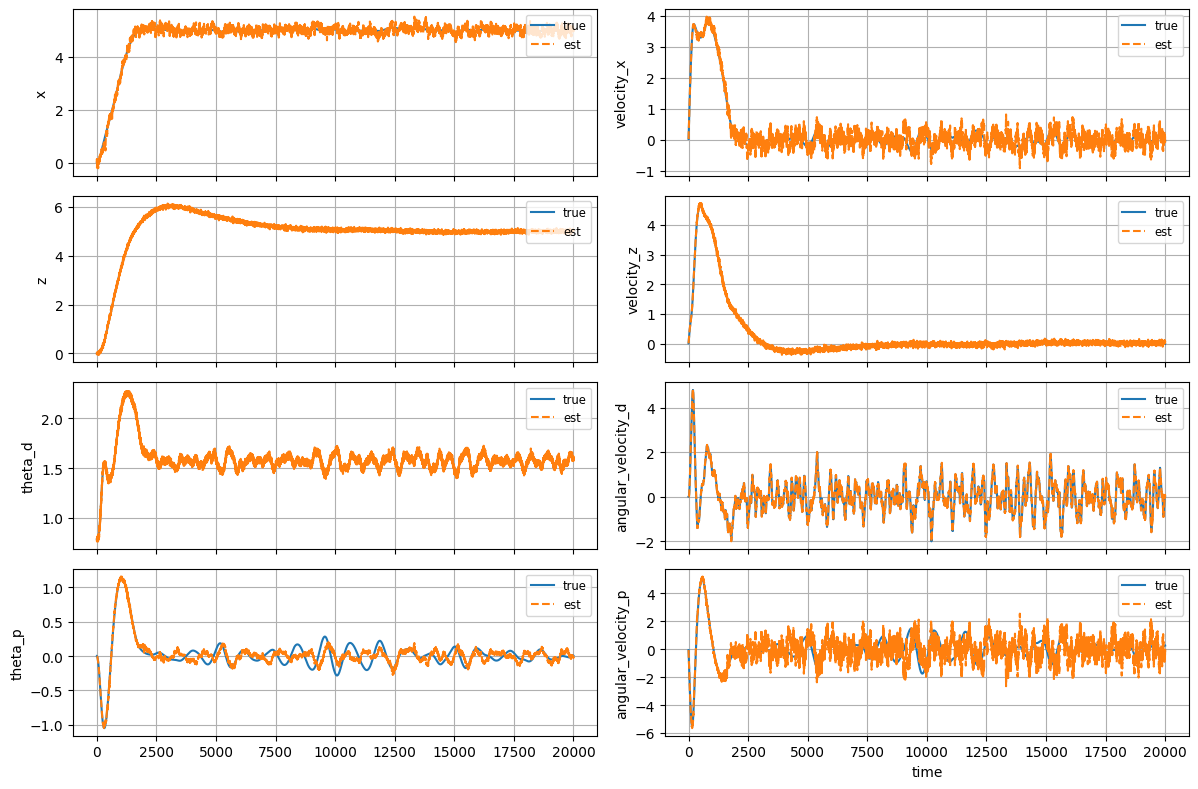

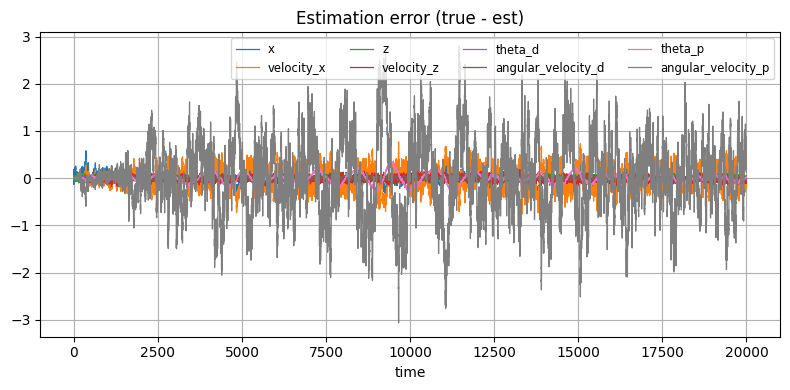

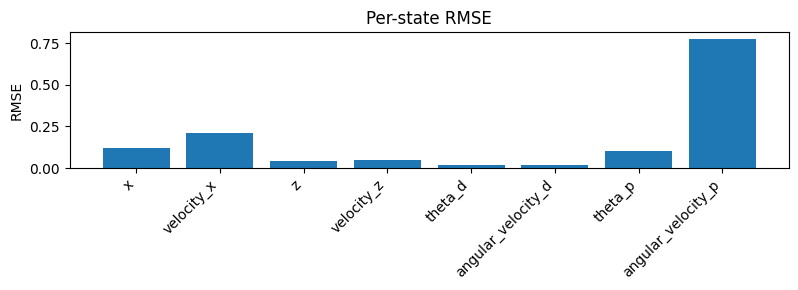

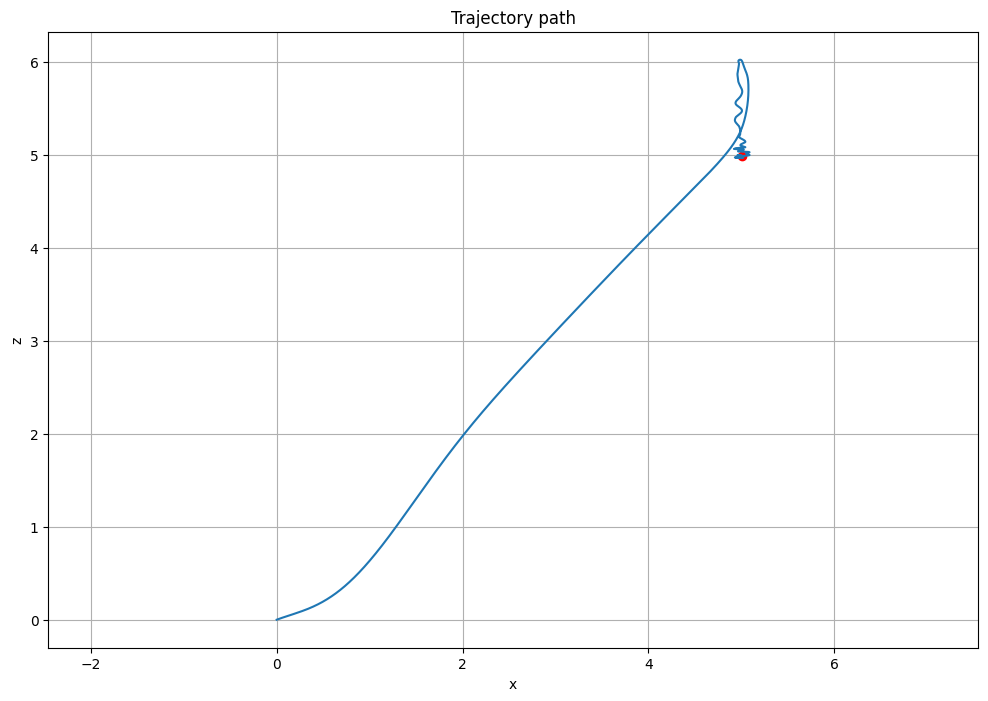

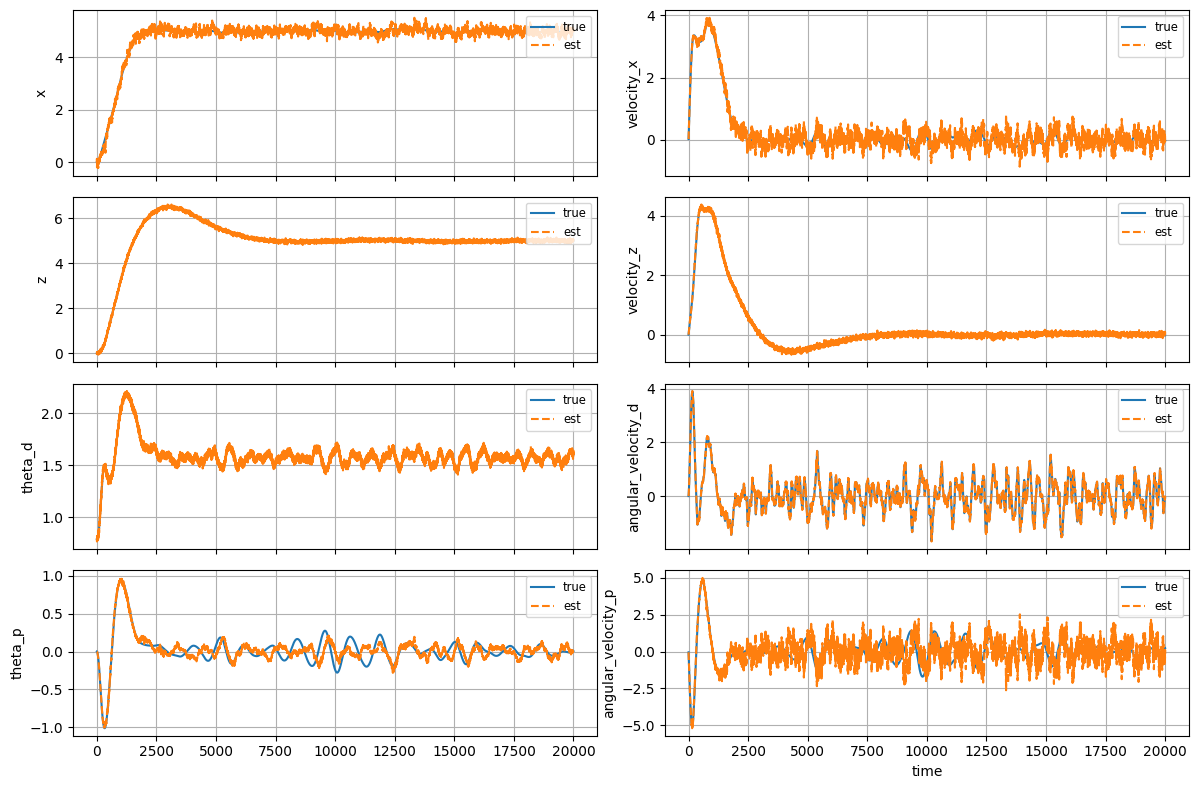

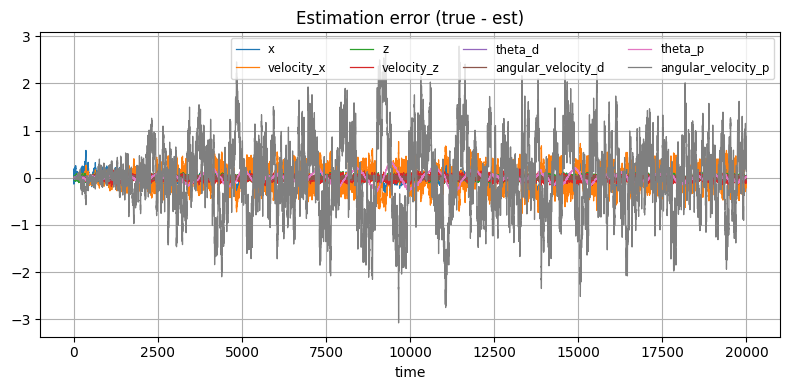

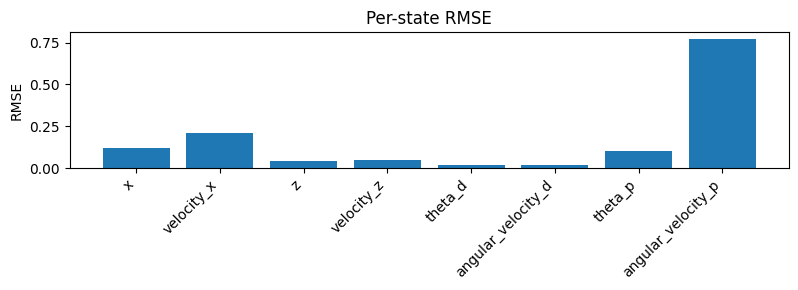

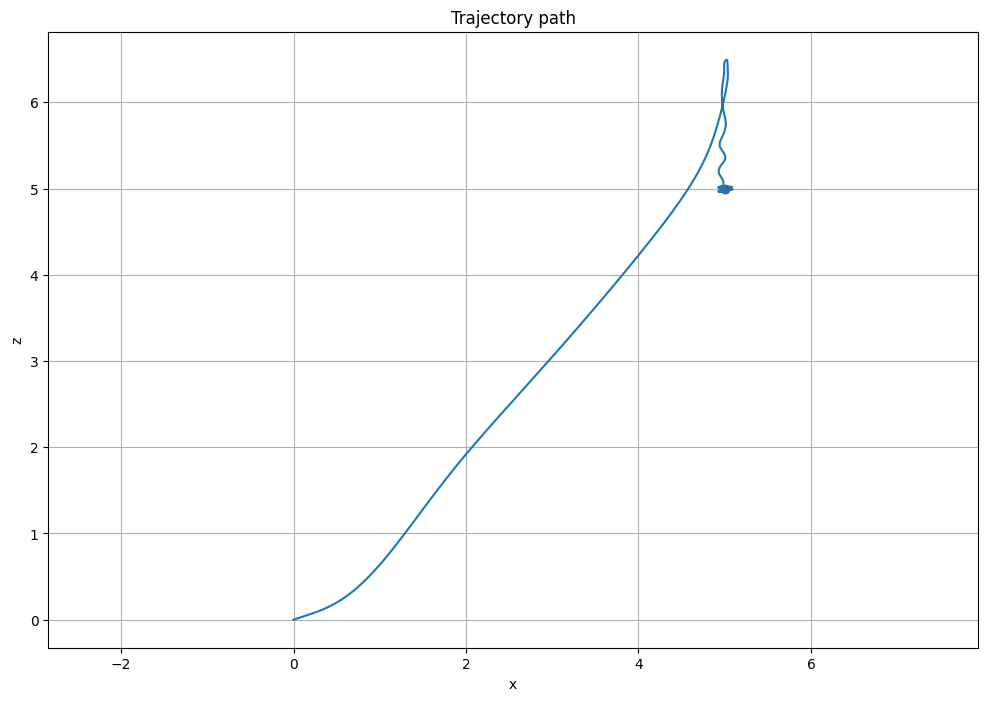

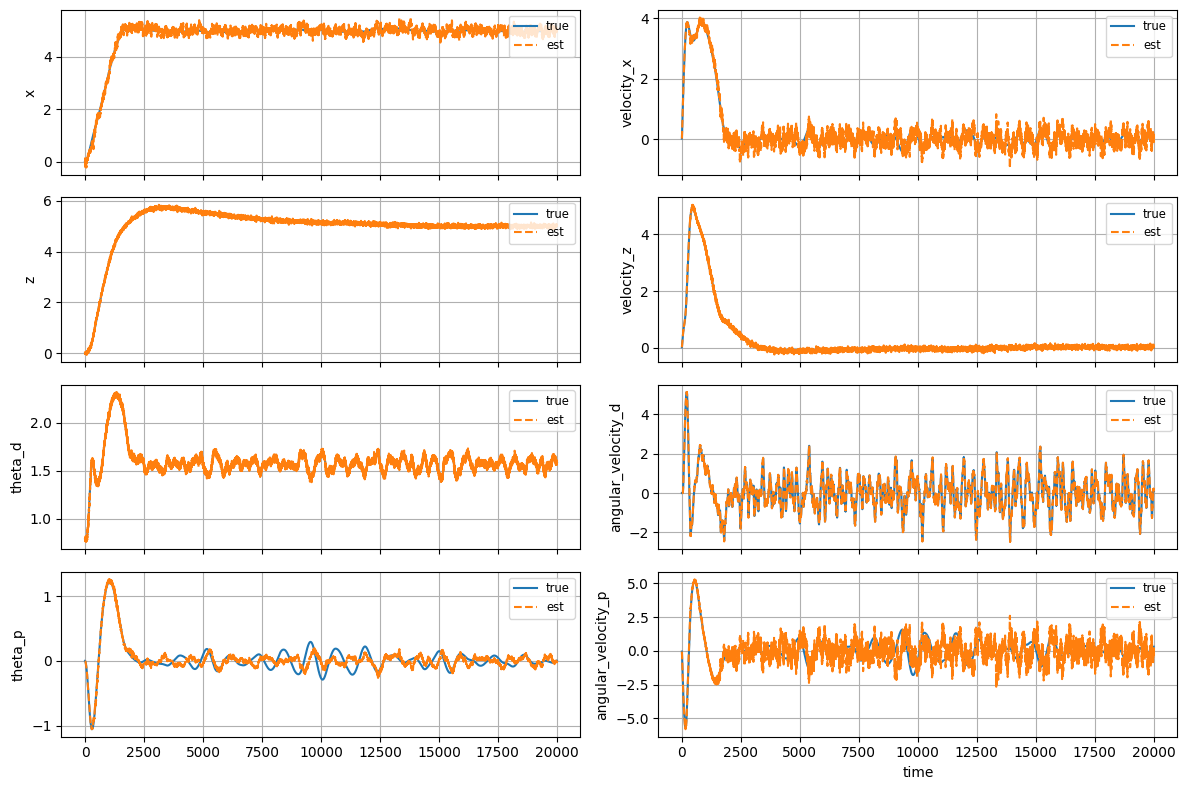

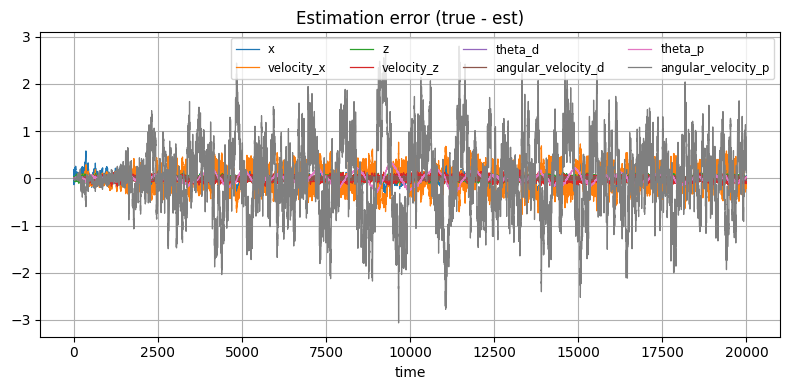

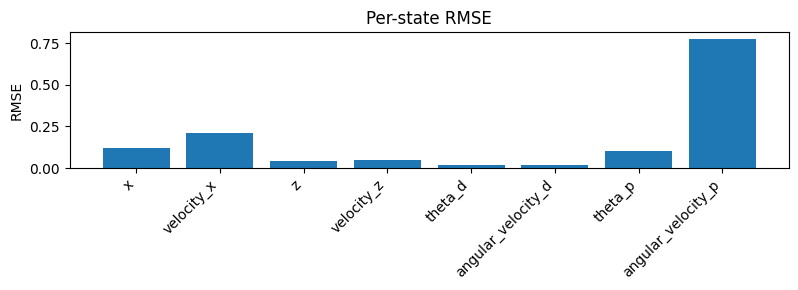

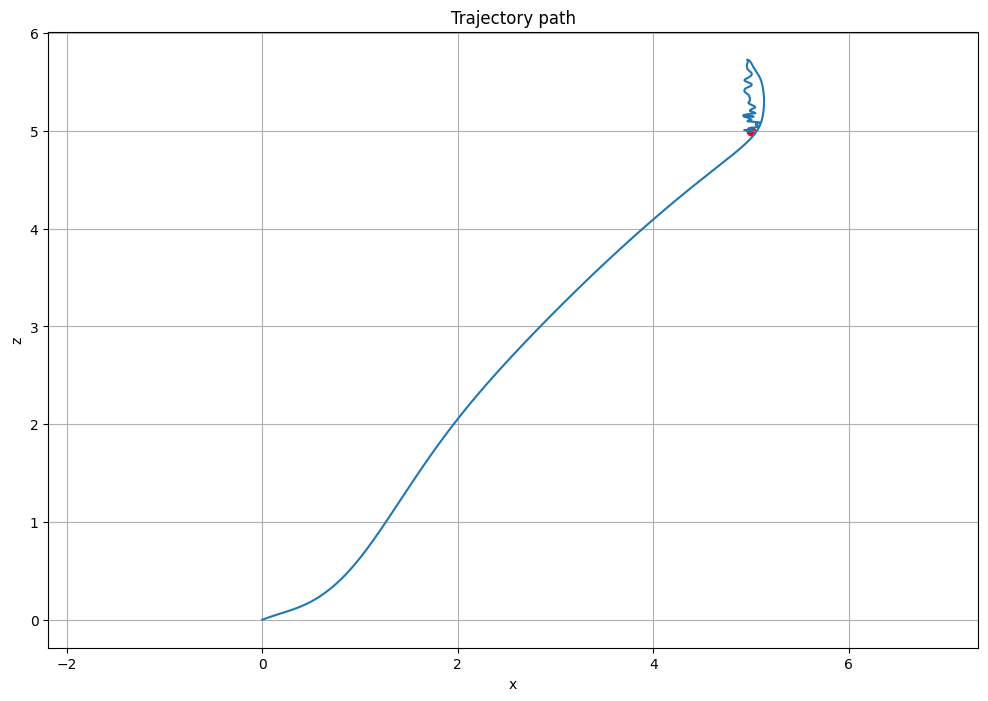

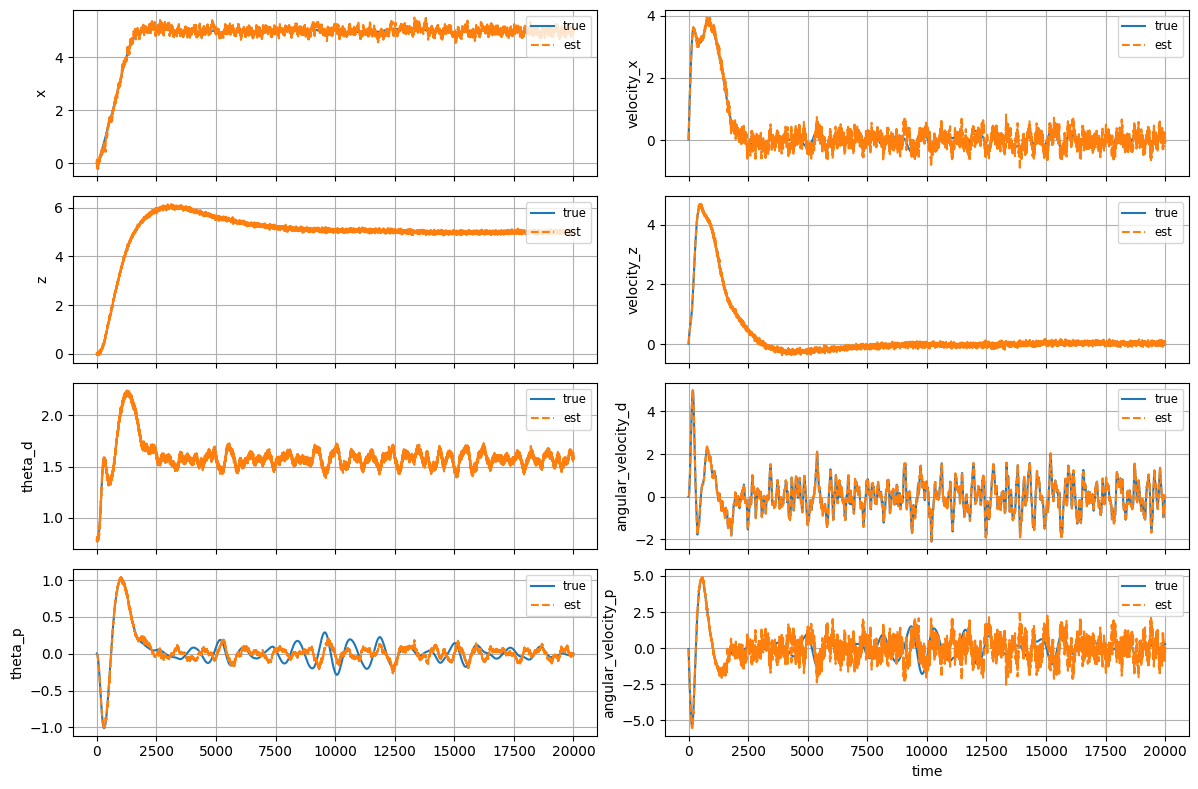

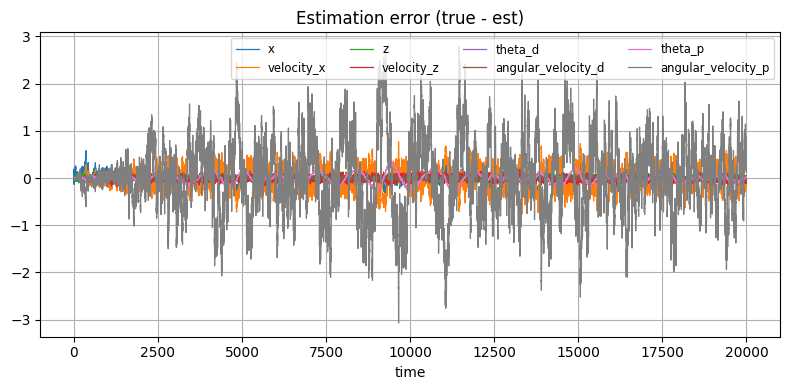

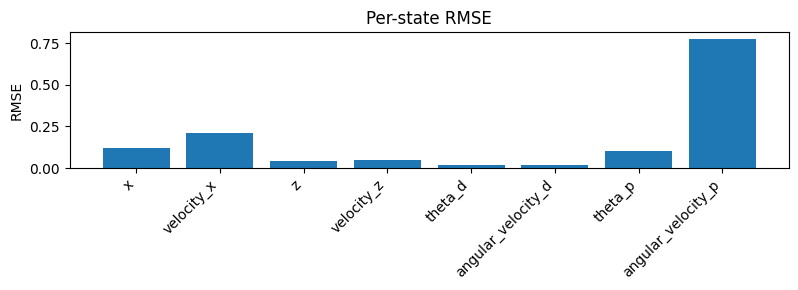

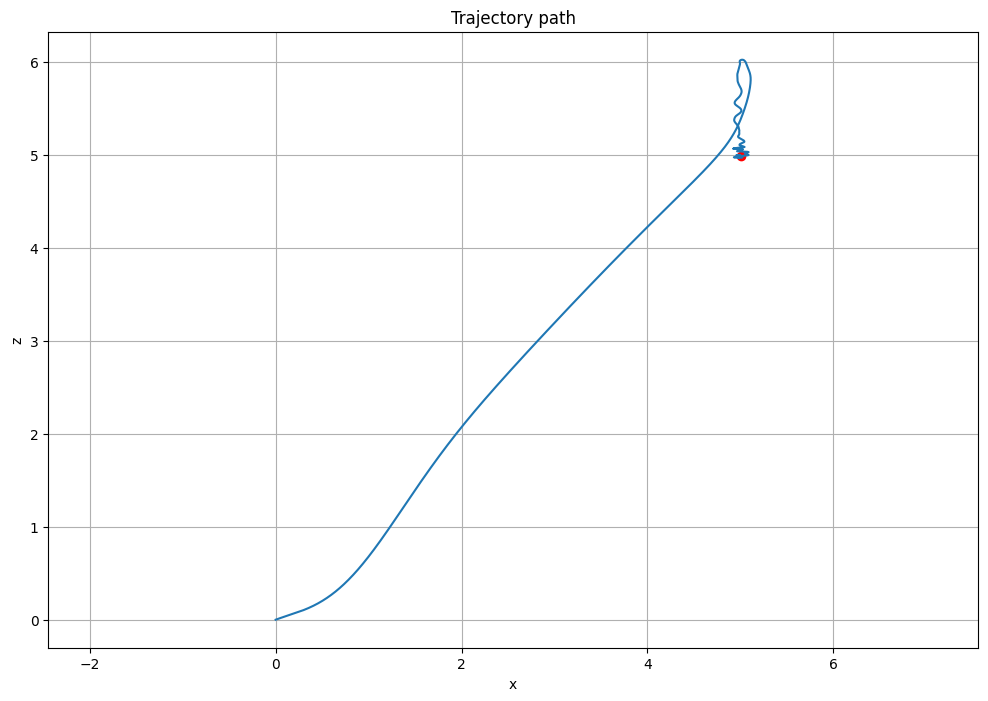

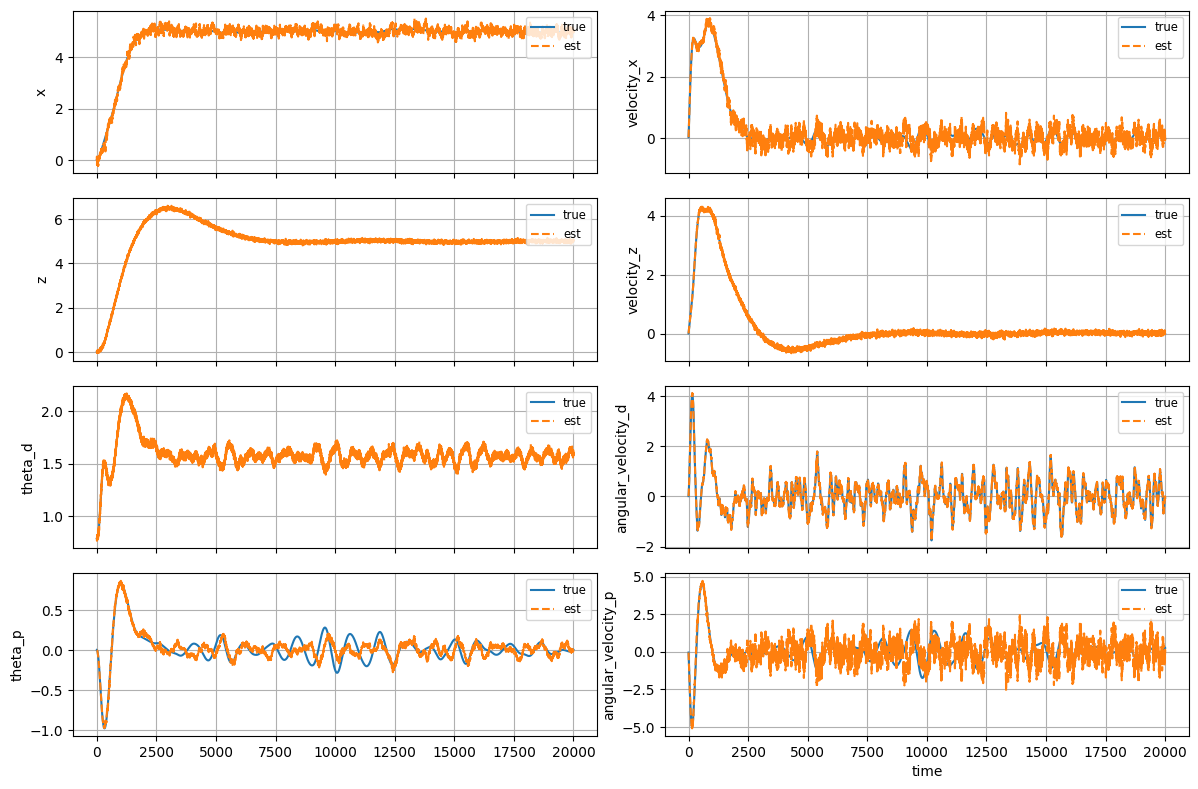

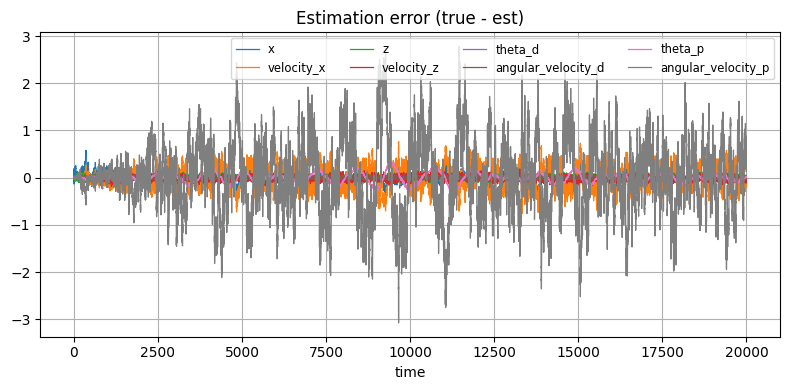

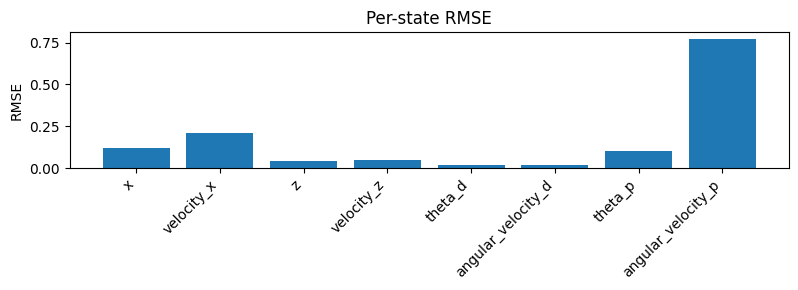

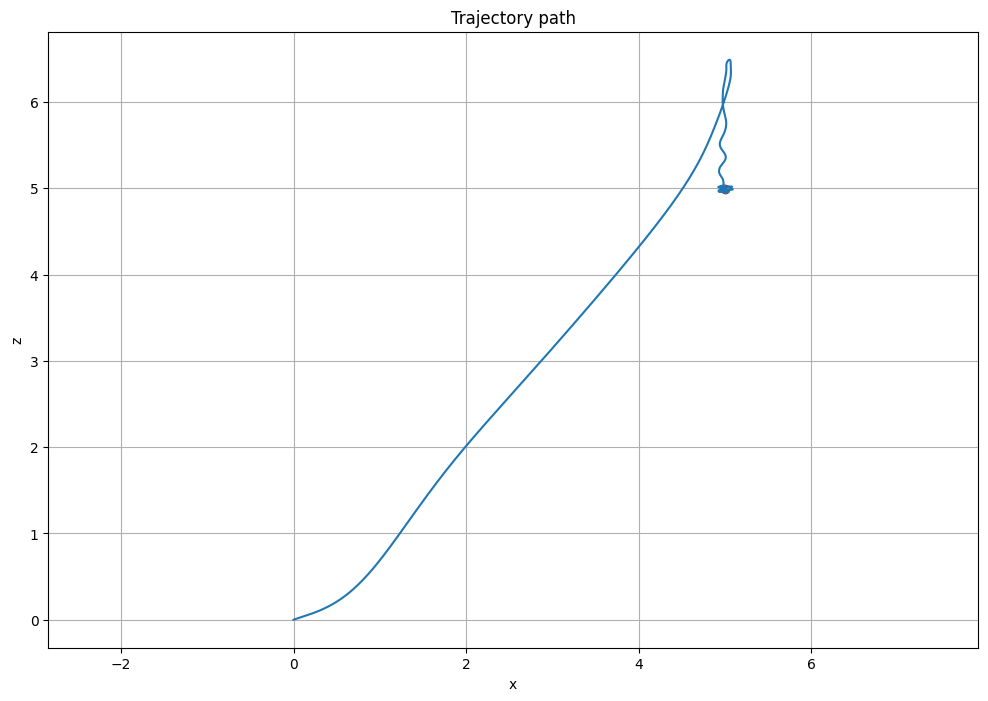

In [ ]:
results = sensitivity(Q_theta_values, 6, Q, R_values)

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(results)

In [ ]:
df

Q_theta_p     R    rmse_x    rmse_z  max_theta_p  mean_effort  \
0         20  0.05  0.796398  0.891230     1.495562     9.384643   
1         20  0.10  0.816089  0.927523     1.237789     7.241640   
2         20  0.20  0.839915  1.004383     1.043319     5.584478   
3         60  0.05  0.805907  0.891235     1.373908     9.670072   
4         60  0.10  0.824749  0.927334     1.131774     7.464209   
5         60  0.20  0.848488  1.003159     1.013693     5.752659   
6        120  0.05  0.818463  0.891686     1.224023    10.054573   
7        120  0.10  0.836252  0.927414     1.010894     7.766623   
8        120  0.20  0.859798  1.002066     0.976498     5.983053   

   settling_time  
0         13.660  
1         11.398  
2          6.837  
3         13.659  
4         11.425  
5          6.842  
6          1.653  
7         11.442  
8          6.842

In [ ]:
pivot = df.pivot(
    index="Q_theta_p",
    columns="R",
    values="max_theta_p"
)

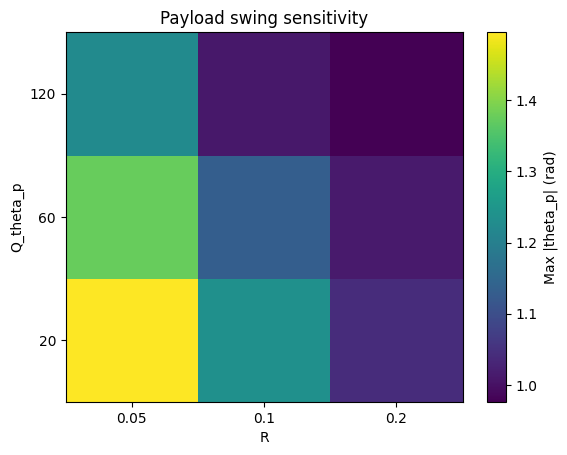

In [ ]:
plt.imshow(pivot, origin="lower", aspect="auto")
plt.colorbar(label="Max |theta_p| (rad)")
plt.xticks(range(len(R_values)), R_values)
plt.yticks(range(len(Q_theta_values)), Q_theta_values)
plt.xlabel("R")
plt.ylabel("Q_theta_p")
plt.title("Payload swing sensitivity")
plt.show()

In [ ]:
df["score"] = (
    2.0 * df["max_theta_p"] +
    1.0 * df["rmse_x"] +
    0.5 * df["mean_effort"]
)

In [ ]:
best = df.sort_values("score").iloc[0]
print(best)

Q_theta_p        20.000000
R                 0.200000
rmse_x            0.839915
rmse_z            1.004383
max_theta_p       1.043319
mean_effort       5.584478
settling_time     6.837000
score             5.718792
Name: 2, dtype: float64


In [ ]:
best

Q_theta_p        20.000000
R                 0.200000
rmse_x            0.839915
rmse_z            1.004383
max_theta_p       1.043319
mean_effort       5.584478
settling_time     6.837000
score             5.718792
Name: 2, dtype: float64

## Observer evaluation

### EKF

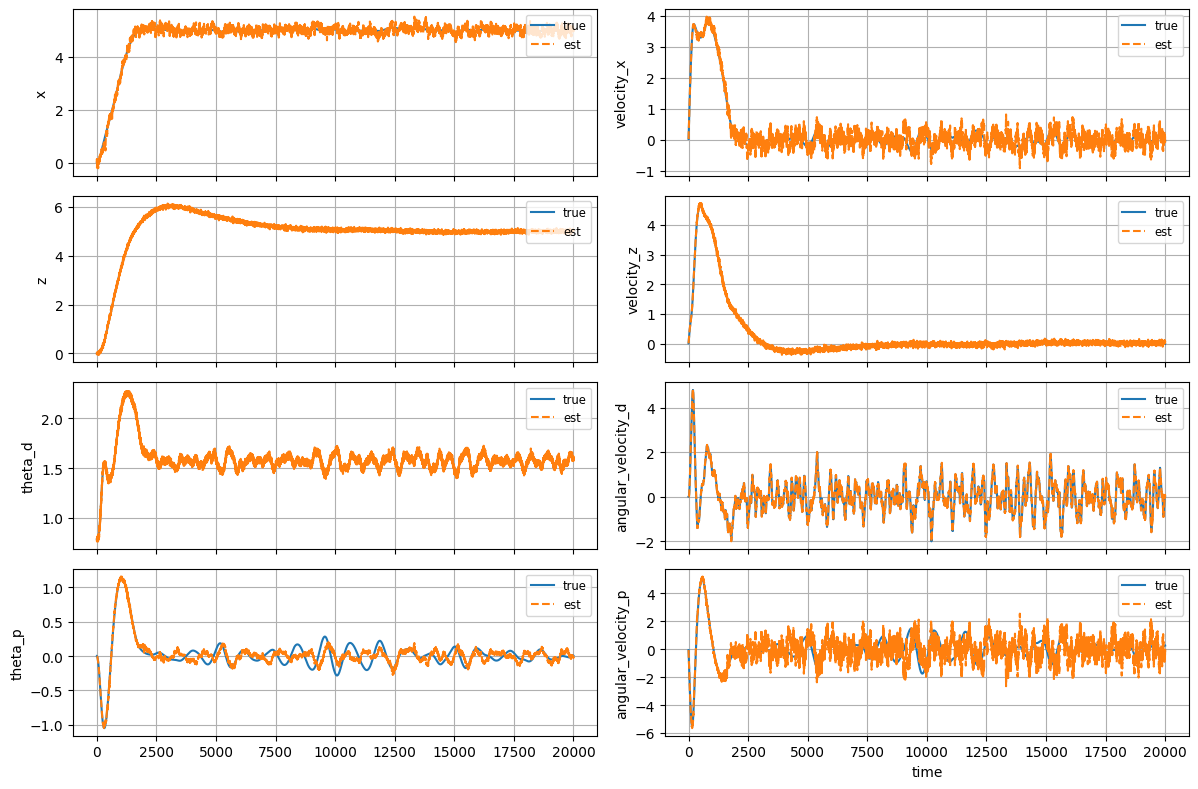

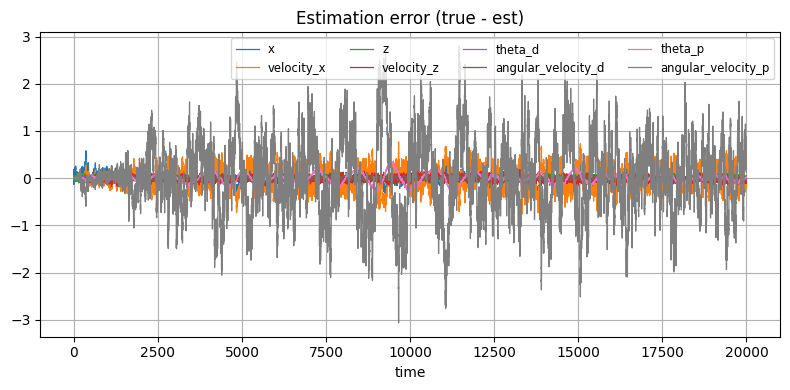

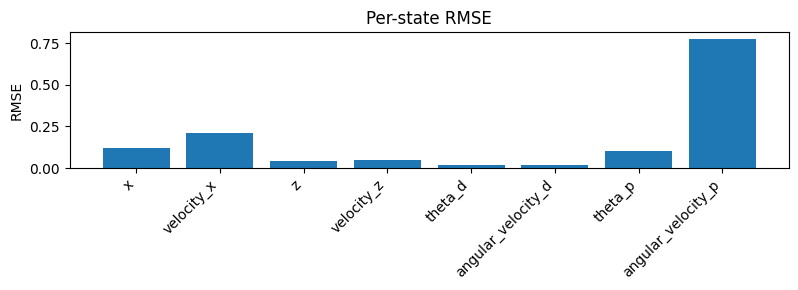

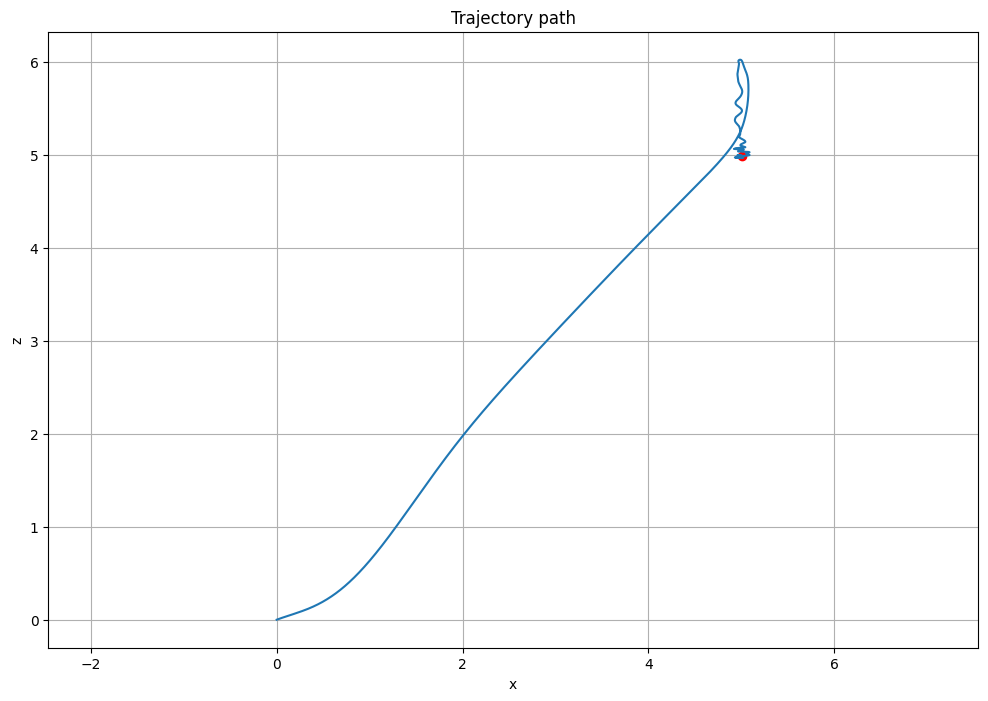

In [ ]:
hist_ekf, hist_hat_ekf, u_hist, t_terminate = baselineSimulation(Q, R, Q_noise, R_noise)

In [ ]:
compute_metrics(hist_ekf, u_ref_, u_hist, t_terminate)

Max package swing (degree):  64.84588585660731
Control Effort Motor 1: [7.45668961]
Control Effort Motor 2: [7.47172792]
Settling after: 11.425 seconds


In [ ]:
rmse_ekf = compute_rmse(hist_ekf, hist_hat_ekf)

In [ ]:
rmse_ekf

array([0.12255718, 0.2094489 , 0.03927492, 0.0459479 , 0.01588137,
       0.01550276, 0.10008313, 0.77635004])

## Naive Observer
unmeasurable = 0

In [ ]:
def NoEKFbaselineSimulation(Q, R, Q_noise, R_noise, seed = 0):
  rng = np.random.default_rng(seed=seed)
  lqr = lqr_controller(x_ref_, u_ref_, A, B, Ki)
  Kr = lqr.get_Kr_(A, B, Q, R)
  x_ = np.array([0, 0, 0, 0, 0.25 * np.pi - 1.0e-3, 0, 0 + 1.0e-3, 0])
  x_hat_ = np.array(
      [0, 0, 0, 0, 0.25 * np.pi, 0, 0, 0]
  )  # initial estmated x
  P = np.eye(8) * 0.1
  integrator_limit = 10.0
  u_min = np.array([0.0, 0.0])
  u_max = np.array([1.5 * (m_d + m_p) * g, 1.5 * (m_d + m_p) * g])
  # main loop
  int_ = np.zeros_like(x_)
  steps = 20000
  hist = []
  u_hist = []
  hist_hat = []
  t_terminate = 0
  for step in range(steps):
    # in controller, it shouldnt have access to the world, it should only know what it can percieve by sensors
    int_ += (x_ref_ - x_hat_) * dt

    u_ = lqr.control_law(x_hat_, int_, Kr)
    u_ = np.clip(u_.flatten(), u_min, u_max)
    u_ = np.reshape(u_, (2, 1))


    dx_hat_pred = systemDynamics.dynamics(x_hat_, u_)
    x_hat_pred_ = x_hat_ + dx_hat_pred * dt
    Df_Dx, _ = systemDynamics.get_jacobian(x_hat_, u_)
    # F = np.eye(8) + Df_Dx * dt

    # P_pred = F @ P @ F.T + Q_noise

    # simulation, this is the real world
    dx_ = systemDynamics.dynamics(x_, u_)
    # dx_[1] += 0.1 * np.sin(2 * np.pi * 1.5 * (step * dt))

    x_ += dx_ * dt

    # measure
    x_meas = x_[0] + rng.normal(0, 0.8)
    z_meas = x_[2] + rng.normal(0, 0.1)
    theta_d_meas = x_[4] + rng.normal(0, 0.02)

    # naive state estimate (no dynamics, no filtering)
    x_hat_ = np.array([
        x_meas,
        0.0,
        z_meas,
        0.0,
        theta_d_meas,
        0.0,
        0.0,
        0.0
    ])

    # remember the past ahh code
    # karn dern tarng korng chun lae ther kue karn rien ruuuu ahh
    x, dx, z, dz, theta_d, dtheta_d, theta_p, dtheta_p = x_
    x_hat, _, z_hat, _, theta_d_hat, _, theta_p_hat, _ = x_hat_
    hist.append(x_.copy())
    hist_hat.append(x_hat_.copy())

    u_hist.append(u_)

    if abs(x - x_ref) < 0.05 and abs(z - z_ref) < 0.05 and t_terminate == 0:
        t_terminate = step

  hist = np.array(hist)
  hist_hat = np.array(hist_hat)

  hist[:, 4] = np.arctan2(np.sin(hist[:, 4]), np.cos(hist[:, 4]))
  hist[:, 6] = np.arctan2(np.sin(hist[:, 6]), np.cos(hist[:, 6]))

  hist_hat[:, 4] = np.arctan2(np.sin(hist_hat[:, 4]), np.cos(hist_hat[:, 4]))
  hist_hat[:, 6] = np.arctan2(np.sin(hist_hat[:, 6]), np.cos(hist_hat[:, 6]))


  states_name = [
      "x",
      "velocity_x",
      "z",
      "velocity_z",
      "theta_d",
      "angular_velocity_d",
      "theta_p",
      "angular_velocity_p",
  ]

  plot_state_history(hist, hist_hat, state_names=states_name, plot_error=True)

  return hist, hist_hat, u_hist, t_terminate

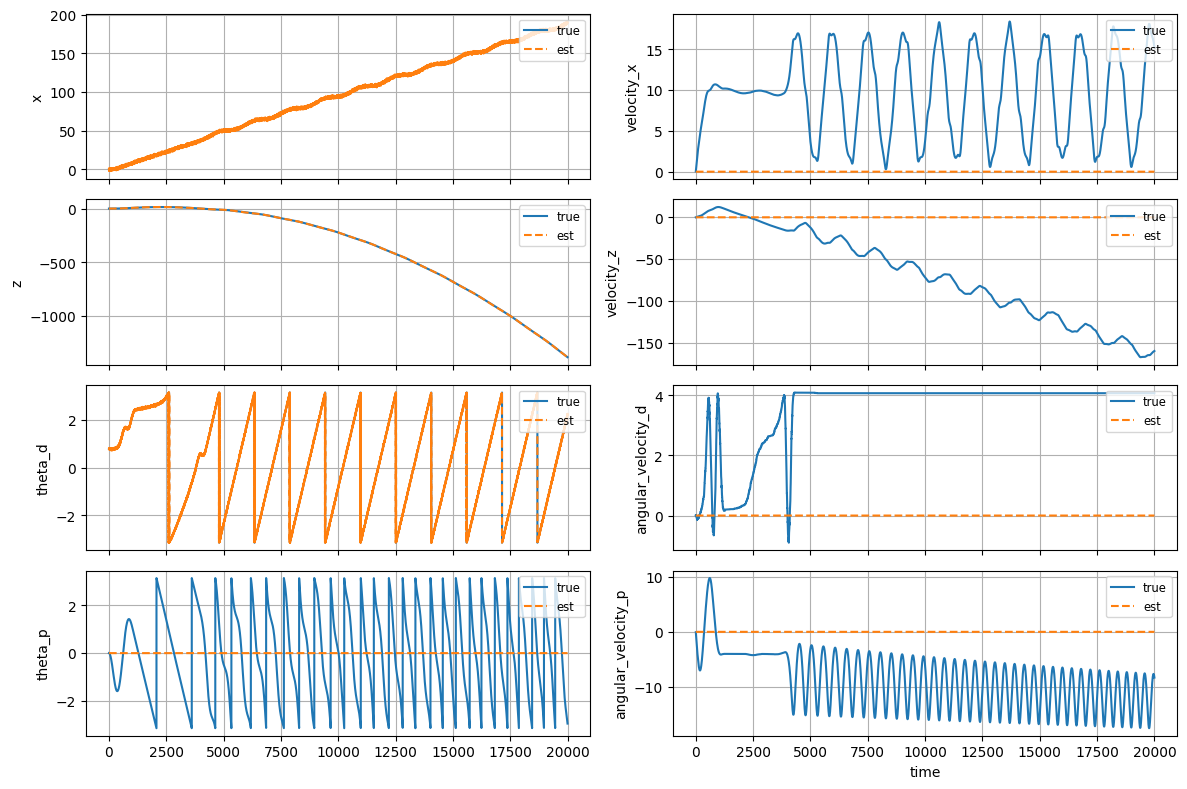

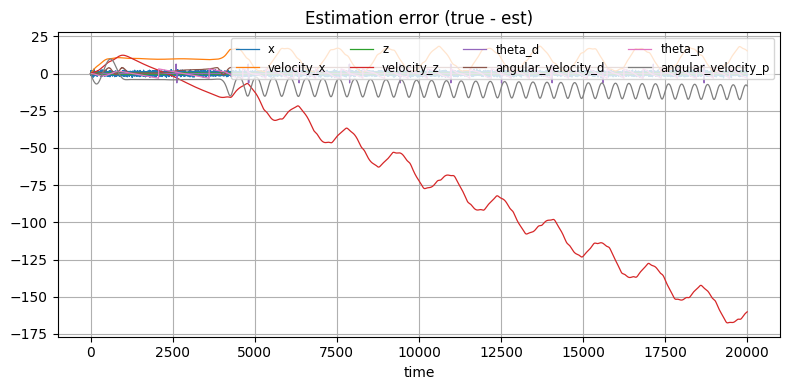

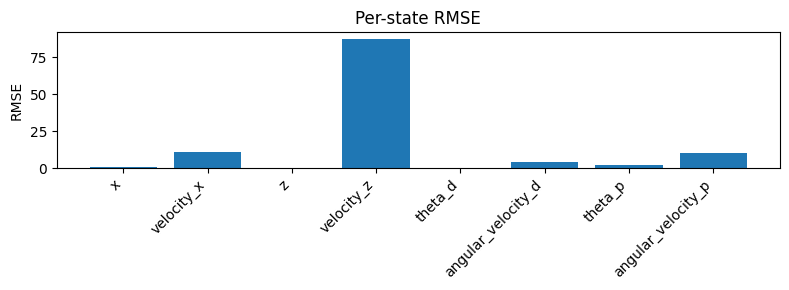

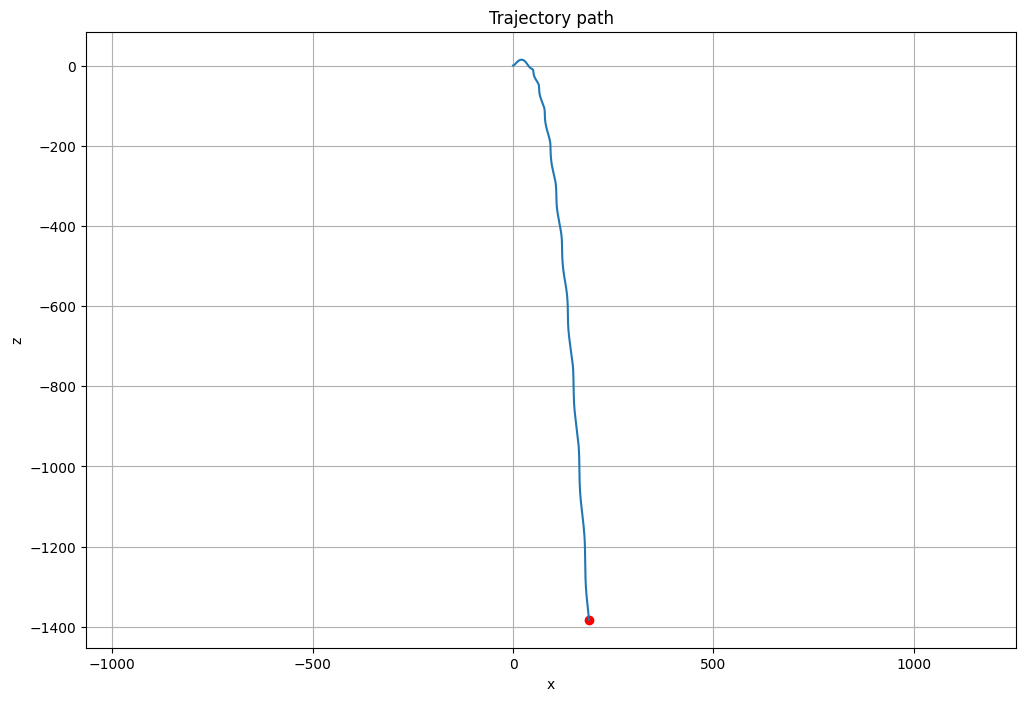

In [ ]:
hist_noekf, hist_hat_noekf, u_hist, t_terminate = NoEKFbaselineSimulation(Q, R, Q_noise, R_noise)

In [ ]:
compute_metrics(hist_noekf, u_ref_, u_hist, t_terminate)

Max package swing (degree):  179.99161458599625
Control Effort Motor 1: [62.05298075]
Control Effort Motor 2: [61.72806512]
The drone never settle


In [ ]:
rmse_noekf = compute_rmse(hist_noekf, hist_hat_noekf)

In [ ]:
state_names = [
    "x",
    "velocity_x",
    "z",
    "velocity_z",
    "theta_d",
    "angular_velocity_d",
    "theta_p",
    "angular_velocity_p",
]

print(f"{'State':<20} | {'EKF RMSE':>10} | {'No EKF RMSE':>12}")
print("-" * 48)

for name, r1, r2 in zip(state_names, rmse_ekf, rmse_noekf):
    print(f"{name:<20} | {r1:10.3f} | {r2:12.3f}")

State                |   EKF RMSE |  No EKF RMSE
------------------------------------------------
x                    |      0.123 |        0.800
velocity_x           |      0.209 |       10.771
z                    |      0.039 |        0.099
velocity_z           |      0.046 |       87.542
theta_d              |      0.016 |        0.284
angular_velocity_d   |      0.016 |        3.732
theta_p              |      0.100 |        1.789
angular_velocity_p   |      0.776 |        9.976


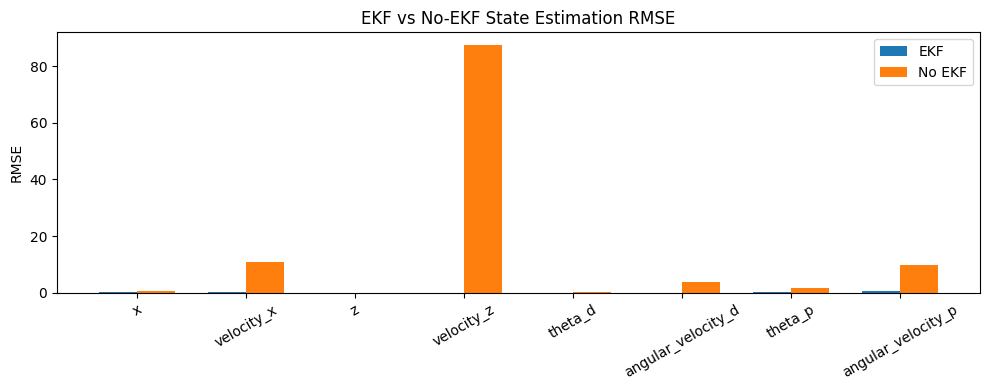

In [ ]:
x = np.arange(len(state_names))
width = 0.35

plt.figure(figsize=(10, 4))
plt.bar(x - width/2, rmse_ekf, width, label="EKF")
plt.bar(x + width/2, rmse_noekf, width, label="No EKF")

plt.xticks(x, state_names, rotation=30)
plt.ylabel("RMSE")
plt.title("EKF vs No-EKF State Estimation RMSE")
plt.legend()
plt.tight_layout()
plt.show()